In [1]:
%load_ext autoreload
%autoreload 2

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import psycopg2
import pandas.io.sql as sqlio
from scipy import stats

In [97]:
sys.path.append(os.path.abspath(os.path.join('../src')))

In [98]:
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")

In [99]:
from preprocessing import PreProcess
from overview import Overview 
overview = Overview()
preProcess = PreProcess()
from plot import Plot
pl = Plot()
from outlier import Outlier
outlier = Outlier()

In [100]:
# Reading the cleaned data
df_clean = pd.read_csv('../data/cleaned_data.csv')

In [101]:
# slecting the numeric and categorical columns for outlier detection
numeric_columns = df_clean.select_dtypes(include=np.number).columns
categorical_columns = df_clean.select_dtypes(include='object').columns
numeric_columns = [el for el in numeric_columns if el not in dlist]

In [102]:
# Relating the columns with their description for plot title 
col_description = pd.read_excel("../data/Field Descriptions.xlsx", index_col=False)
col_description["Fields"] = col_description["Fields"].apply(lambda x: x.replace(' ', '_').lower())

In [103]:
df_clean.head()

,bearer_id,start,start_ms,end,end_ms,dur._(ms),imsi,msisdn/number,imei,last_location_name,...,total_ul_(bytes),total_dl_(bytes),social_media,google,email,youtube,netflix,gaming,other,total_data
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,36749741.0,308879636.0,1570185.0,2905912.0,3701304.0,18355943.0,17855187.0,292426453.0,180558843.0,345629377.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,53800391.0,653384965.0,1933278.0,4414096.0,937385.0,39359124.0,35565545.0,609920783.0,541959383.0,707185356.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,27883638.0,279807335.0,1726277.0,10229119.0,3363124.0,34425237.0,23751202.0,229980251.0,414908351.0,307690973.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,43324218.0,846028530.0,657493.0,11811761.0,2070983.0,36534765.0,15092588.0,810387875.0,761837216.0,889352748.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,38542814.0,569138589.0,912788.0,7748843.0,2110349.0,34222253.0,17539799.0,531237049.0,564619822.0,607681403.0


In [104]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   bearer_id                       150001 non-null  float64
 1   start                           150001 non-null  object 
 2   start_ms                        150001 non-null  float64
 3   end                             150001 non-null  object 
 4   end_ms                          150001 non-null  float64
 5   dur._(ms)                       150001 non-null  float64
 6   imsi                            150001 non-null  float64
 7   msisdn/number                   150001 non-null  float64
 8   imei                            150001 non-null  float64
 9   last_location_name              150001 non-null  object 
 10  avg_rtt_dl_(ms)                 150001 non-null  float64
 11  avg_rtt_ul_(ms)                 150001 non-null  float64
 12  avg_bearer_tp_dl

### Outlier Detection

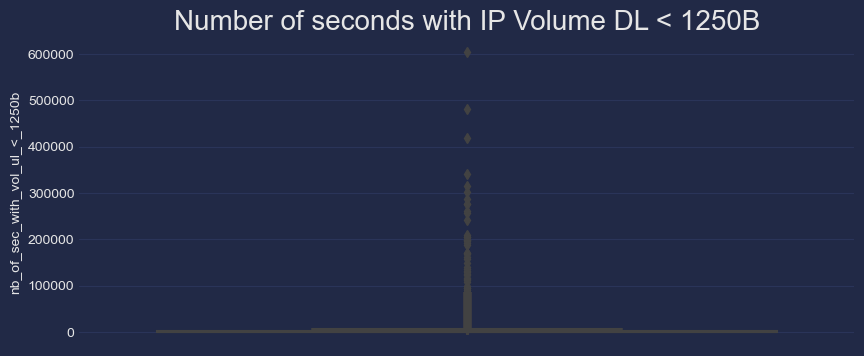

In [105]:
pl.plot_box(df_clean, 'nb_of_sec_with_vol_ul_<_1250b', 'Number of seconds with IP Volume DL < 1250B')

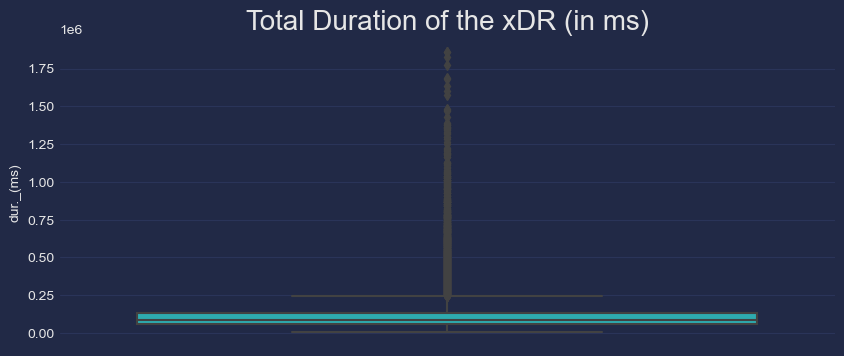

In [106]:
pl.plot_box(df_clean, 'dur._(ms)', 'Total Duration of the xDR (in ms)')

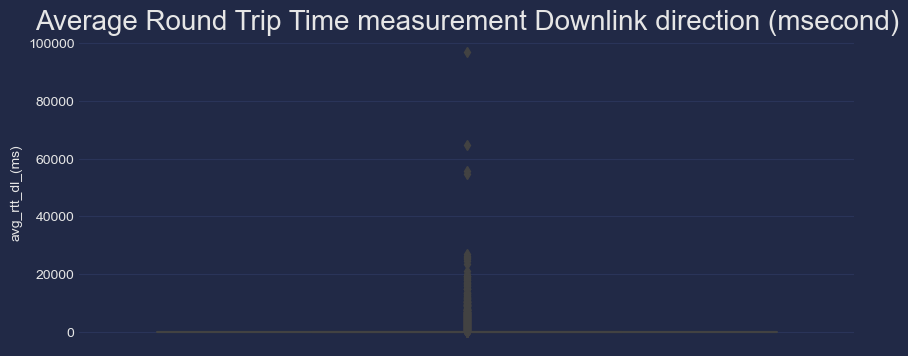

In [107]:
pl.plot_box(df_clean, 'avg_rtt_dl_(ms)', 'Average Round Trip Time measurement Downlink direction (msecond)')

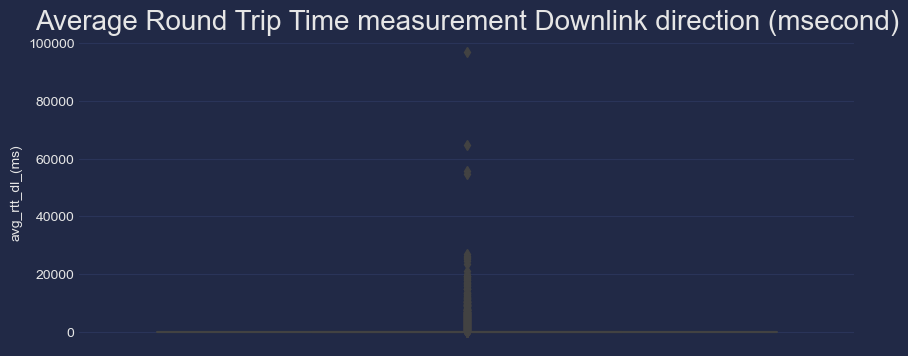

In [108]:
pl.plot_box(df_clean, 'avg_rtt_dl_(ms)', 'Average Round Trip Time measurement Downlink direction (msecond)')

In [109]:
display(outlier.outlier_overview(df_clean, 'activity_duration_ul_(ms)'))

,bearer_id,start,start_ms,end,end_ms,dur._(ms),imsi,msisdn/number,imei,last_location_name,...,total_ul_(bytes),total_dl_(bytes),social_media,google,email,youtube,netflix,gaming,other,total_data
38,7.277826e+18,4/18/2019 15:40,982.0,4/25/2019 15:40,33.0,604800.0,2.082095e+14,3.376394e+10,8.616400e+13,T86868A,...,49727524.0,267689014.0,2289164.0,6968427.0,3695834.0,38187388.0,29681520.0,224511685.0,307407730.0,317416538.0
538,7.277826e+18,4/23/2019 23:45,419.0,4/24/2019 23:45,313.0,86399.0,2.082017e+14,3.366726e+10,8.637690e+13,D84798A,...,36072646.0,236941106.0,59893.0,11310981.0,3416872.0,22114141.0,19928600.0,206991579.0,50676948.0,273013752.0
557,1.304243e+19,4/23/2019 23:56,766.0,4/24/2019 23:56,385.0,86400.0,2.082017e+14,3.366344e+10,8.637690e+13,D83916A,...,29908196.0,642815619.0,1327791.0,7856235.0,3824288.0,32149459.0,15464300.0,608015977.0,232625154.0,672723815.0
635,1.304243e+19,4/24/2019 0:09,773.0,4/25/2019 0:09,678.0,86399.0,2.082015e+14,3.366045e+10,8.637690e+13,D92712B,...,64954877.0,727897527.0,2728868.0,9731639.0,297957.0,36350335.0,26796840.0,702026210.0,56357265.0,792852404.0
655,7.277826e+18,4/24/2019 0:11,540.0,4/25/2019 0:11,513.0,86399.0,2.082017e+14,3.365830e+10,3.520271e+13,K14666C,...,42450423.0,632356629.0,3232621.0,13832461.0,1593857.0,6442885.0,9825074.0,630092914.0,245490618.0,674807052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148359,1.304243e+19,4/29/2019 7:08,248.0,4/30/2019 7:08,208.0,86399.0,2.082014e+14,3.366916e+10,8.637690e+13,T85713B,...,59572655.0,419875450.0,2152719.0,10395848.0,1456603.0,25229155.0,26845633.0,401863117.0,341357023.0,479448105.0
148408,1.304243e+19,4/29/2019 7:09,731.0,4/30/2019 7:09,745.0,86400.0,2.082017e+14,3.366057e+10,8.637690e+13,T85784A,...,44841066.0,579178272.0,3580949.0,8644318.0,3483958.0,13622092.0,43983326.0,534598296.0,33817072.0,624019338.0
148994,1.304243e+19,4/29/2019 7:16,675.0,4/30/2019 7:16,689.0,86400.0,2.082018e+14,3.366725e+10,8.637690e+13,D85941B,...,45124501.0,90680481.0,1801564.0,1421594.0,916167.0,36340337.0,17796819.0,77151179.0,772400034.0,135804982.0
148998,7.277826e+18,4/29/2019 7:16,452.0,4/30/2019 7:16,469.0,86400.0,2.082017e+14,3.376216e+10,8.637690e+13,T78199C,...,46062056.0,503379057.0,591475.0,9065039.0,3326554.0,35909436.0,26417933.0,471801222.0,332886430.0,549441113.0


It can be seen that most of the column have outliers

In [110]:
# outliers_dict = outlier.calculate_num_outliers_zscore(df, num_cols)
for col in numeric_columns:
    sample_outliers = outlier.calculate_num_outliers_zscore(df_clean[col])
    print(f"Outliers from Z-scores method of {col}", len(sample_outliers))

Outliers from Z-scores method of dur._(ms) 2214
Outliers from Z-scores method of avg_rtt_dl_(ms) 886
Outliers from Z-scores method of avg_rtt_ul_(ms) 869
Outliers from Z-scores method of avg_bearer_tp_dl_(kbps) 2983
Outliers from Z-scores method of avg_bearer_tp_ul_(kbps) 4269
Outliers from Z-scores method of tcp_dl_retrans._vol_(bytes) 950
Outliers from Z-scores method of tcp_ul_retrans._vol_(bytes) 166
Outliers from Z-scores method of dl_tp_<_50_kbps_(%) 3486
Outliers from Z-scores method of 50_kbps_<_dl_tp_<_250_kbps_(%) 3491
Outliers from Z-scores method of 250_kbps_<_dl_tp_<_1_mbps_(%) 3163
Outliers from Z-scores method of dl_tp_>_1_mbps_(%) 3479
Outliers from Z-scores method of ul_tp_<_10_kbps_(%) 2220
Outliers from Z-scores method of 10_kbps_<_ul_tp_<_50_kbps_(%) 2035
Outliers from Z-scores method of 50_kbps_<_ul_tp_<_300_kbps_(%) 1039
Outliers from Z-scores method of ul_tp_>_300_kbps_(%) 608
Outliers from Z-scores method of activity_duration_dl_(ms) 3558
Outliers from Z-scores 

In [111]:
df_clean = outlier.handle_outliers(df_clean, numeric_columns)

/home/eyaya/Desktop/10_Academy/week_1/Week1_Challenge/User-Analytics-in-the-Telecom-Industry/src/outlier.py:39: RuntimeWarning: divide by zero encountered in log
  df[col] = [np.log(x) for x in df[col]]


In [112]:
# outliers_dict = outlier.calculate_num_outliers_zscore(df, num_cols)
for col in numeric_columns:
    sample_outliers = outlier.calculate_num_outliers_zscore(df_clean[col])
    print(f"Outliers from Z-scores method of {col}", len(sample_outliers))

Outliers from Z-scores method of dur._(ms) 500
Outliers from Z-scores method of avg_rtt_dl_(ms) 0


/home/eyaya/Desktop/10_Academy/week_1/Week1_Challenge/User-Analytics-in-the-Telecom-Industry/src/outlier.py:58: RuntimeWarning: invalid value encountered in double_scalars
  z_score = (i-mean)/std


Outliers from Z-scores method of avg_rtt_ul_(ms) 0
Outliers from Z-scores method of avg_bearer_tp_dl_(kbps) 0
Outliers from Z-scores method of avg_bearer_tp_ul_(kbps) 0
Outliers from Z-scores method of tcp_dl_retrans._vol_(bytes) 99
Outliers from Z-scores method of tcp_ul_retrans._vol_(bytes) 800
Outliers from Z-scores method of dl_tp_<_50_kbps_(%) 0
Outliers from Z-scores method of 50_kbps_<_dl_tp_<_250_kbps_(%) 0
Outliers from Z-scores method of 250_kbps_<_dl_tp_<_1_mbps_(%) 0
Outliers from Z-scores method of dl_tp_>_1_mbps_(%) 0
Outliers from Z-scores method of ul_tp_<_10_kbps_(%) 0
Outliers from Z-scores method of 10_kbps_<_ul_tp_<_50_kbps_(%) 0
Outliers from Z-scores method of 50_kbps_<_ul_tp_<_300_kbps_(%) 0
Outliers from Z-scores method of ul_tp_>_300_kbps_(%) 0
Outliers from Z-scores method of activity_duration_dl_(ms) 0
Outliers from Z-scores method of activity_duration_ul_(ms) 0
Outliers from Z-scores method of dur._(ms).1 500
Outliers from Z-scores method of nb_of_sec_with_v

In [113]:
columns_with_outliers = [col for col in numeric_columns if len(outlier.calculate_num_outliers_zscore(df_clean[col]))>0]

In [114]:
df_outlier = df_clean[columns_with_outliers]

In [115]:
df_outlier.shape

(150001, 29)

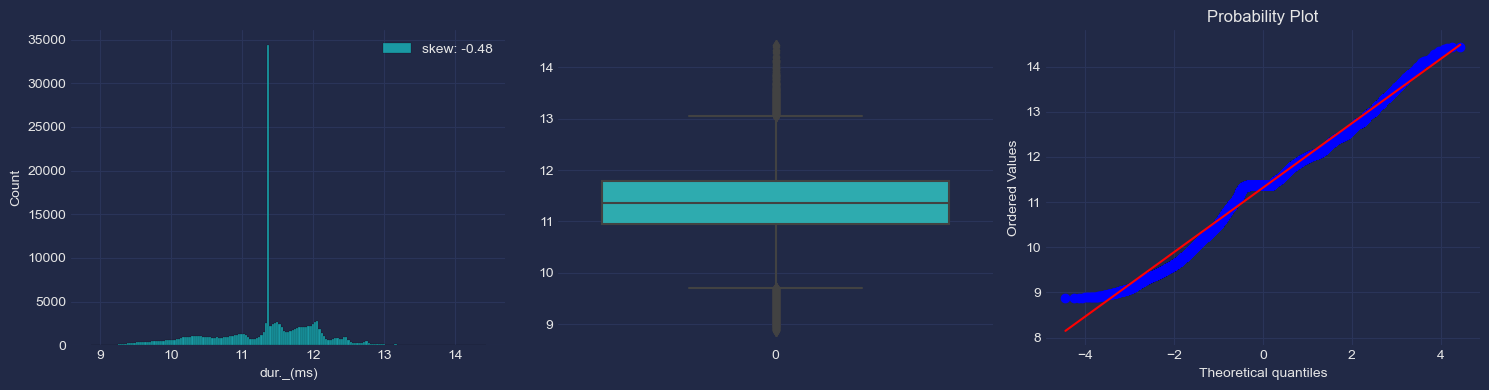

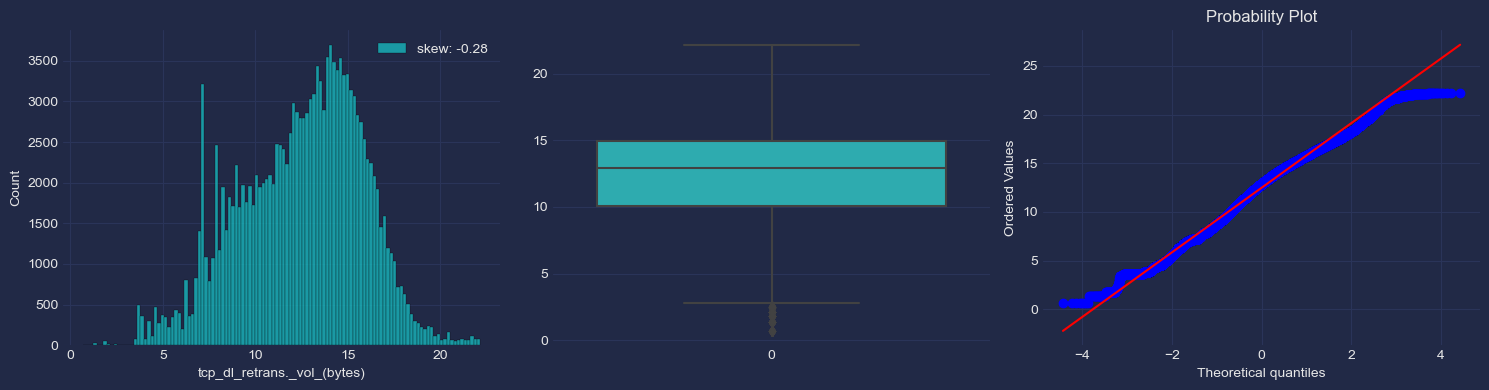

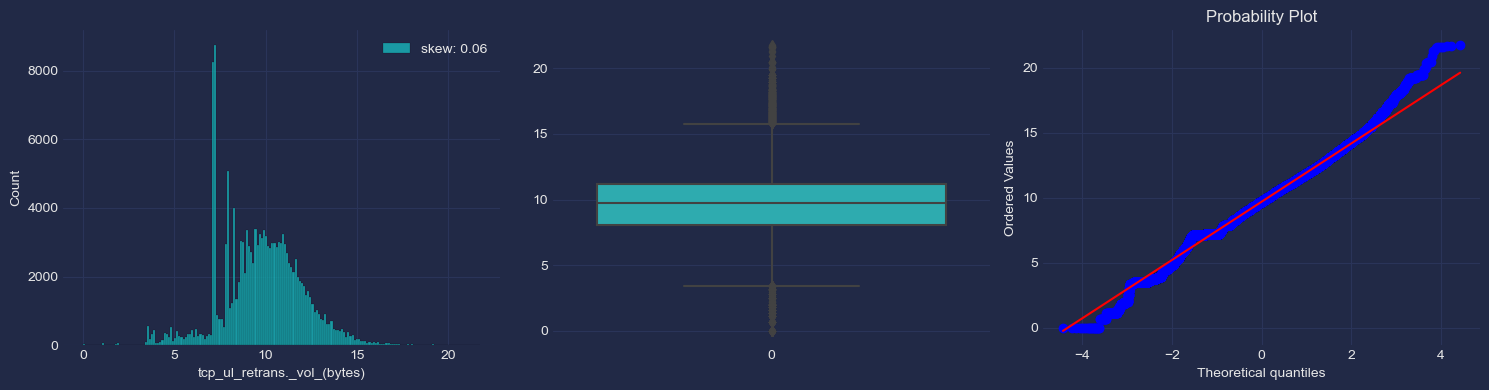

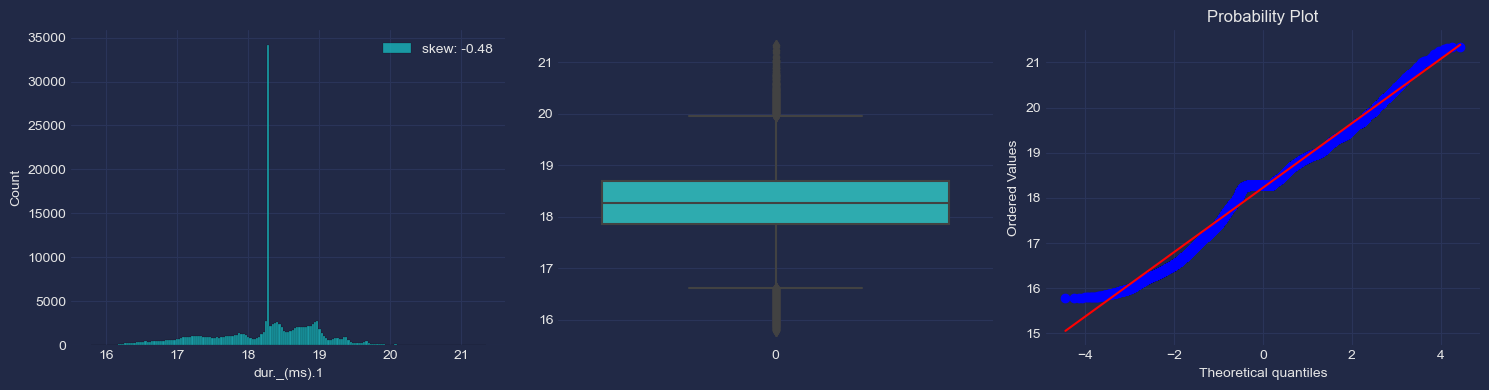

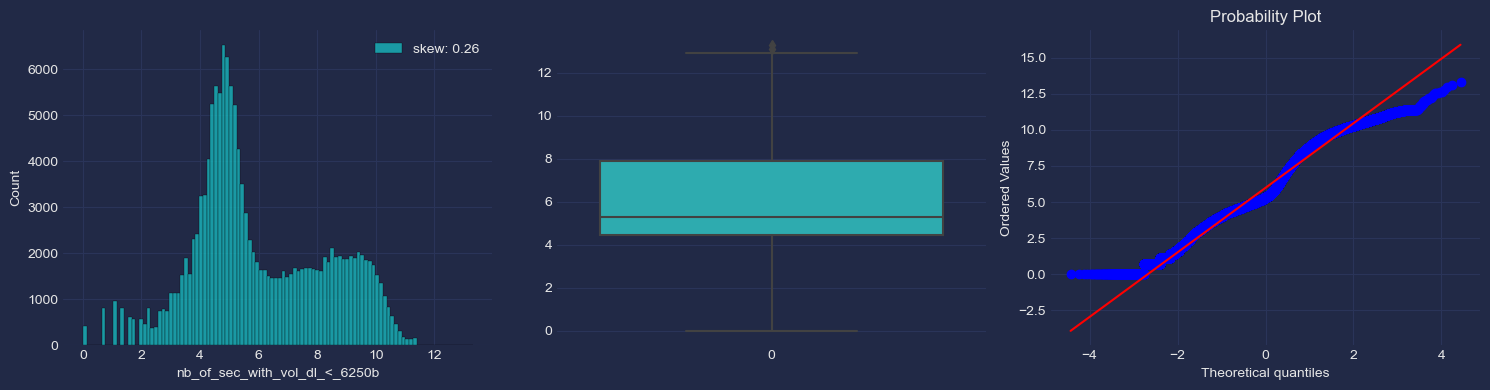

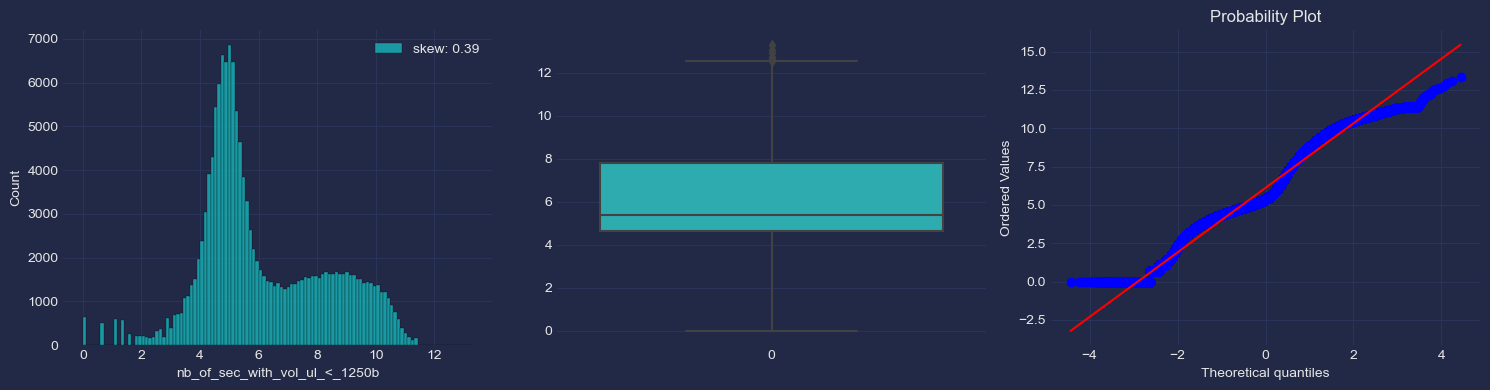

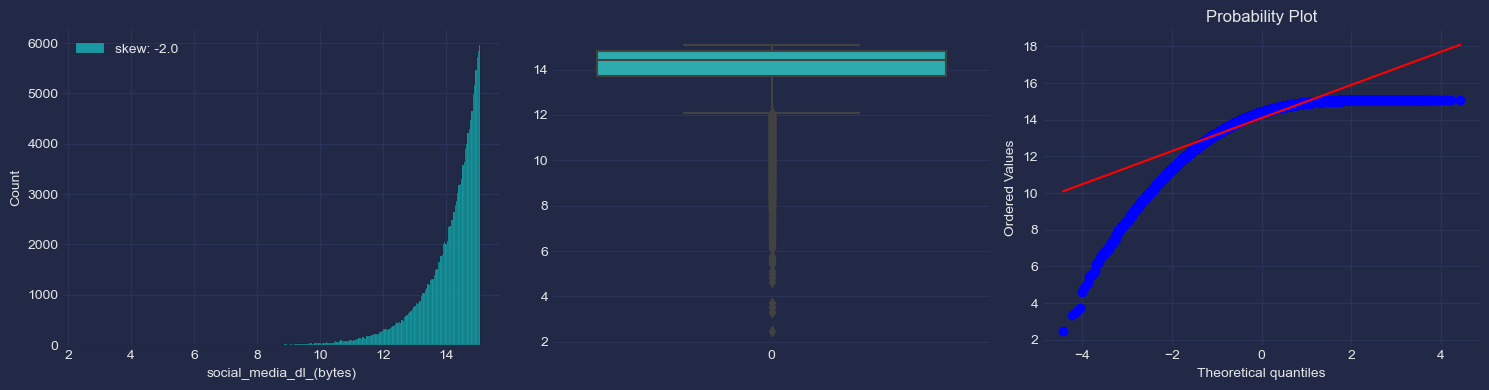

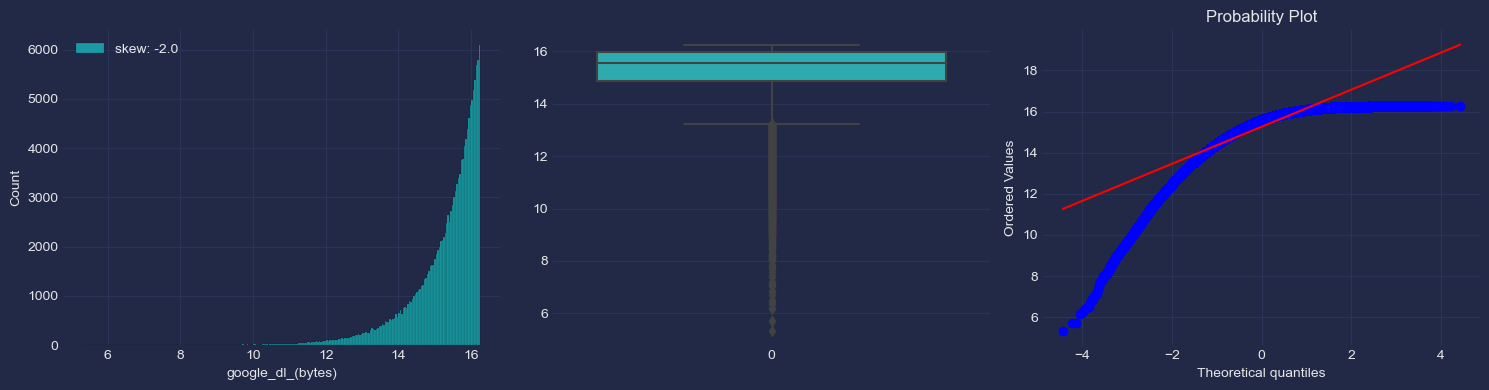

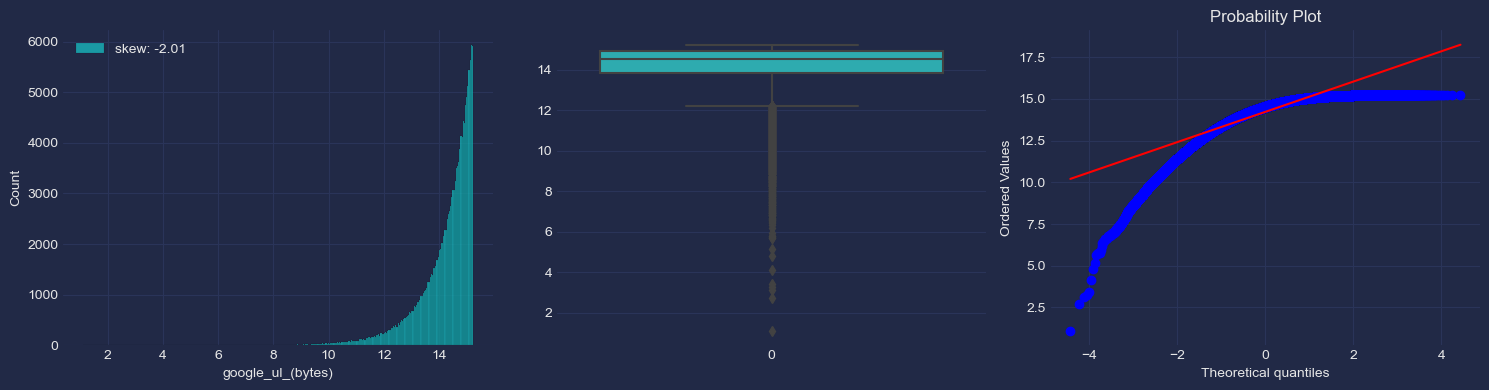

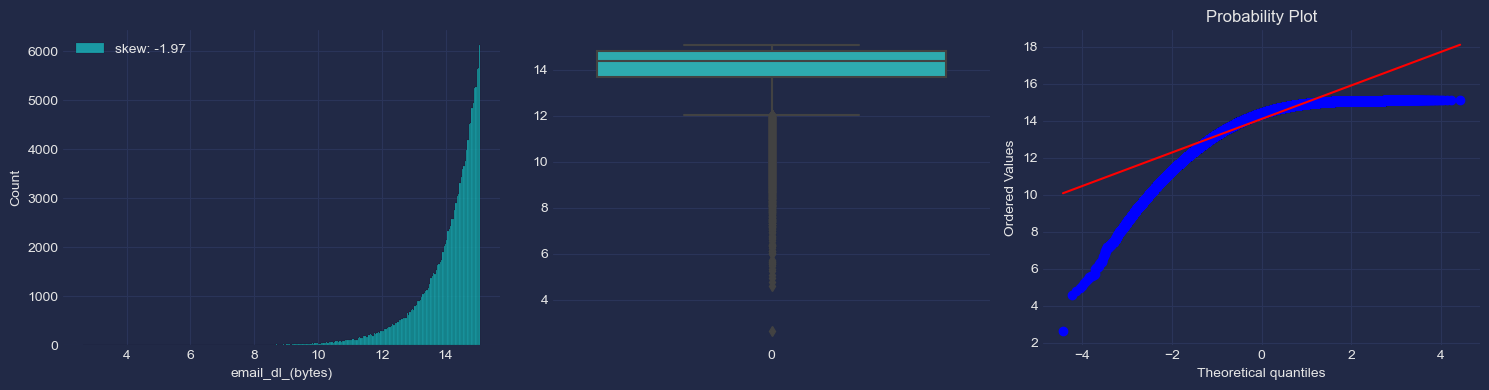

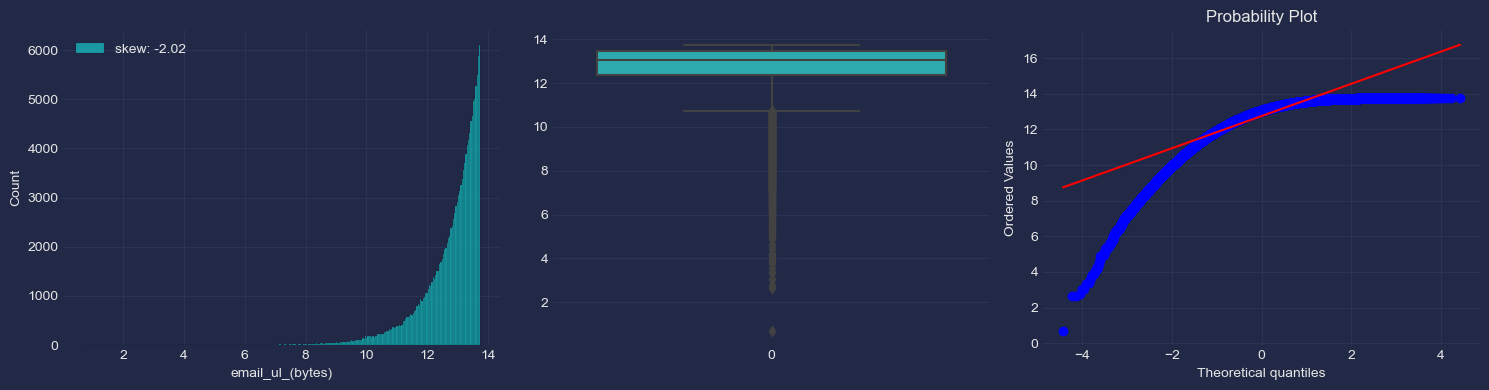

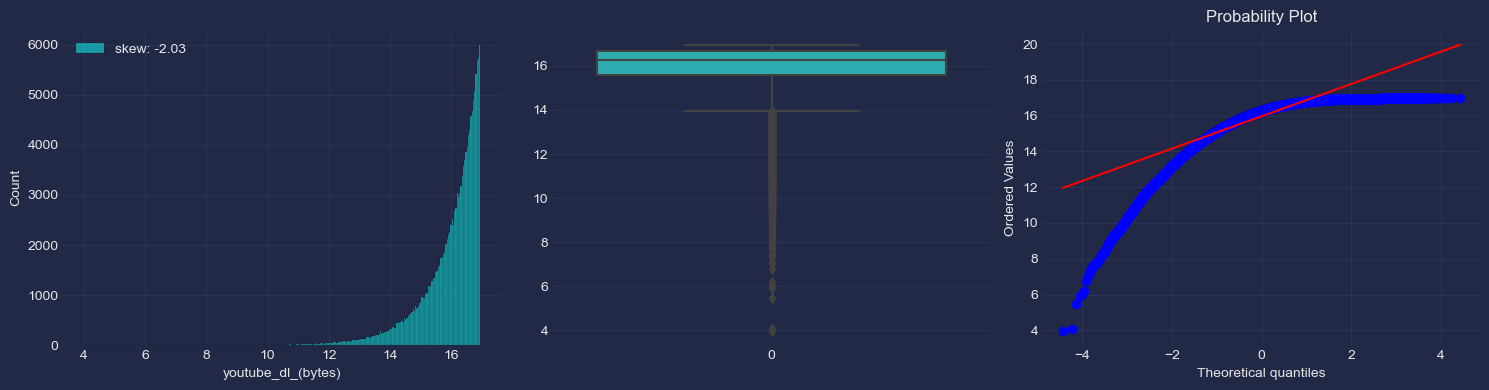

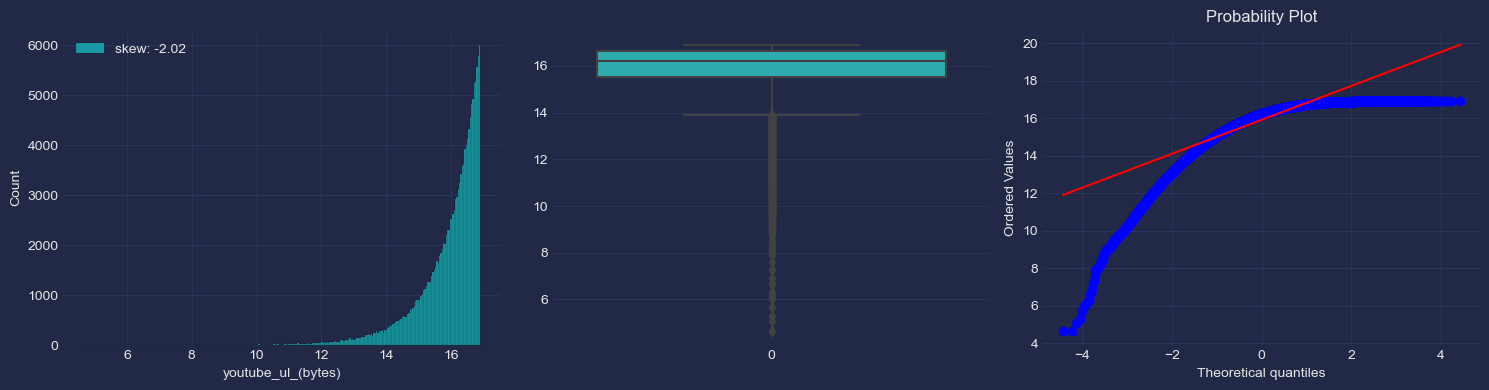

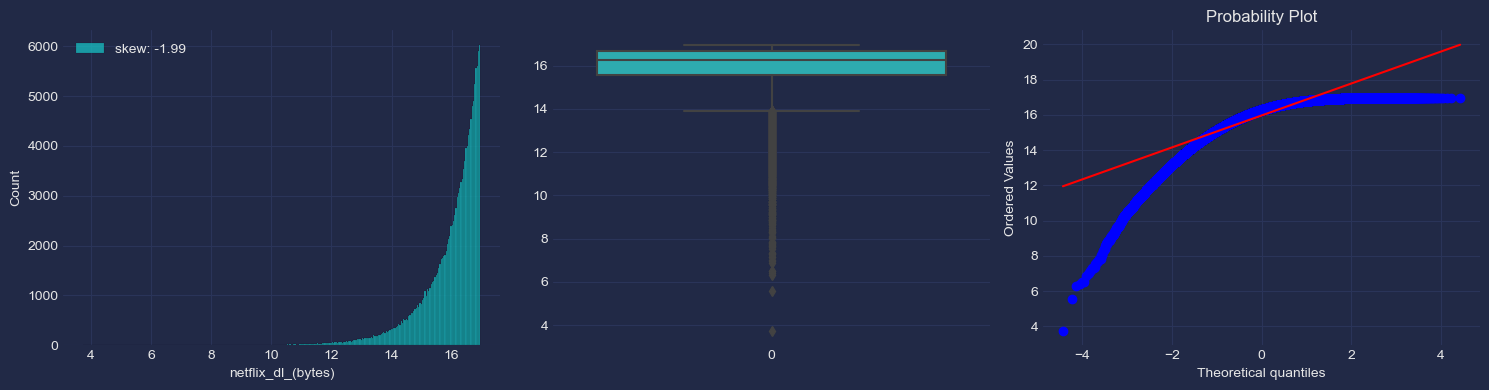

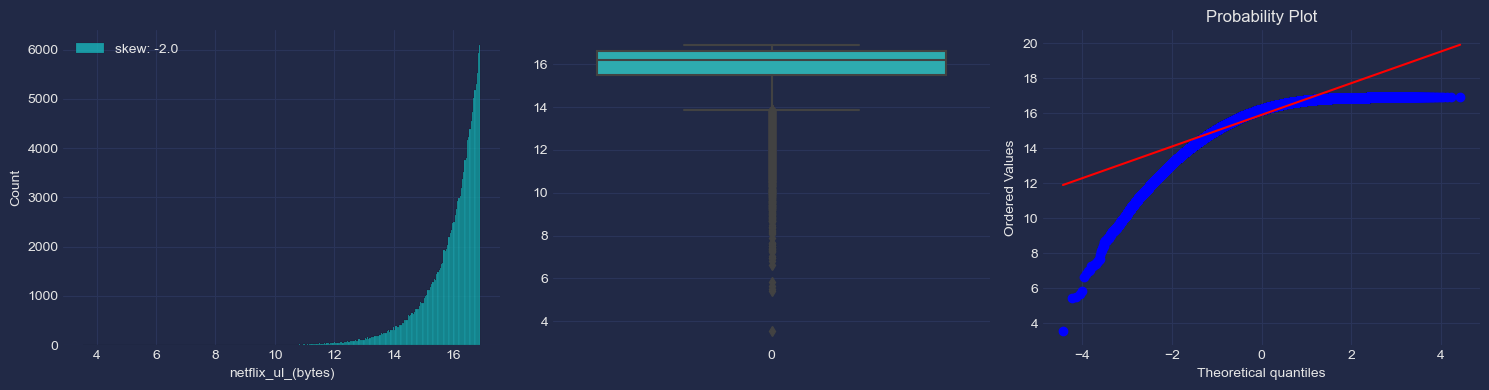

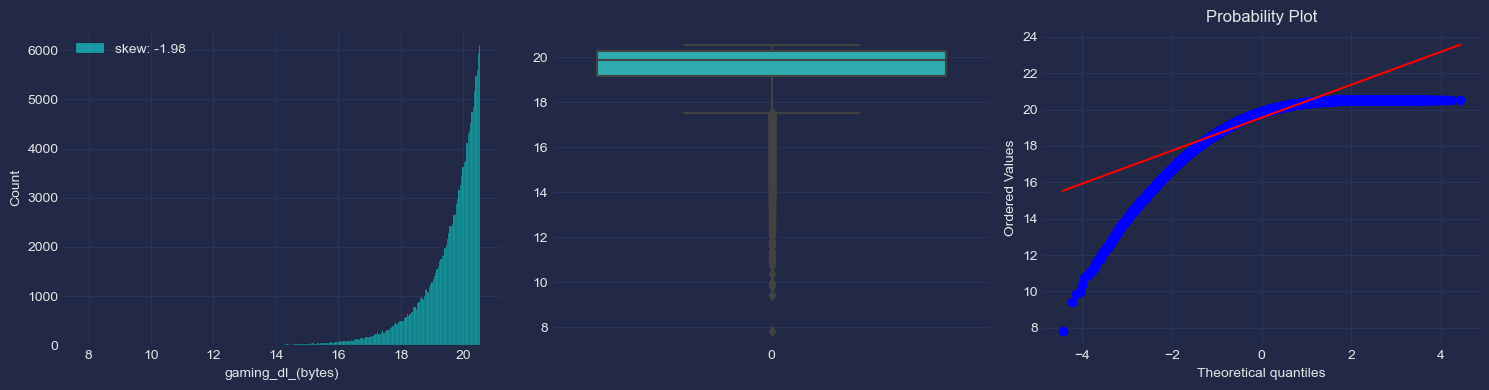

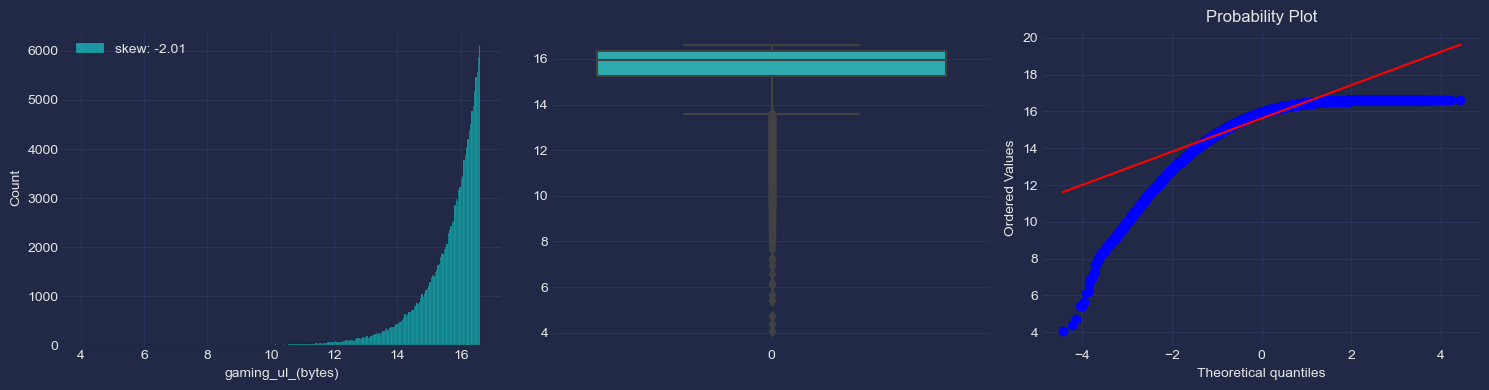

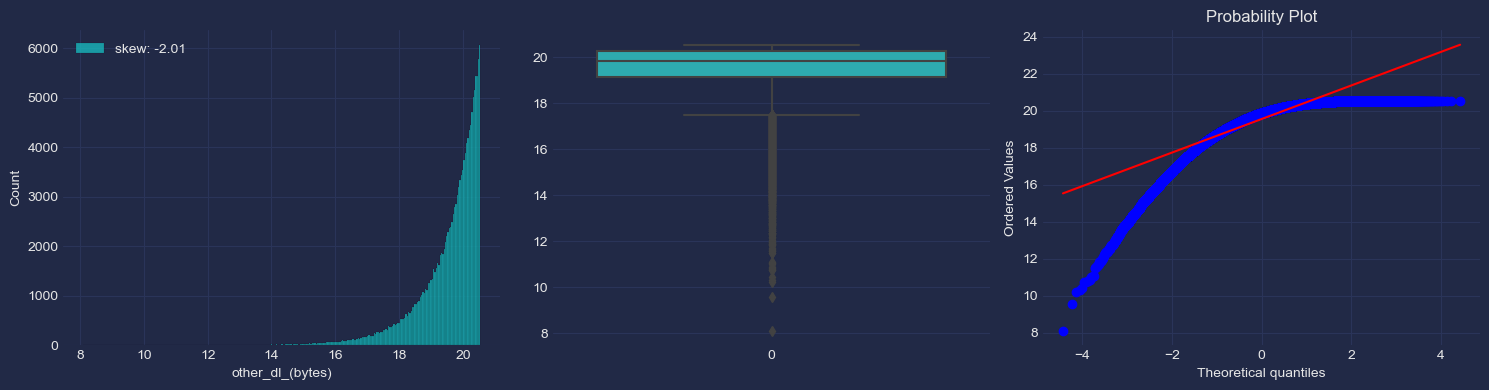

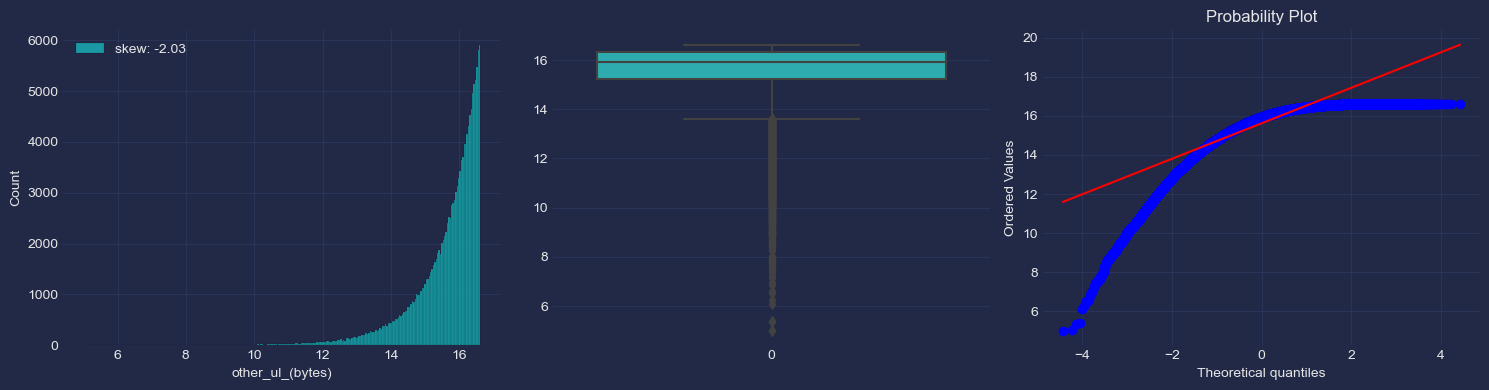

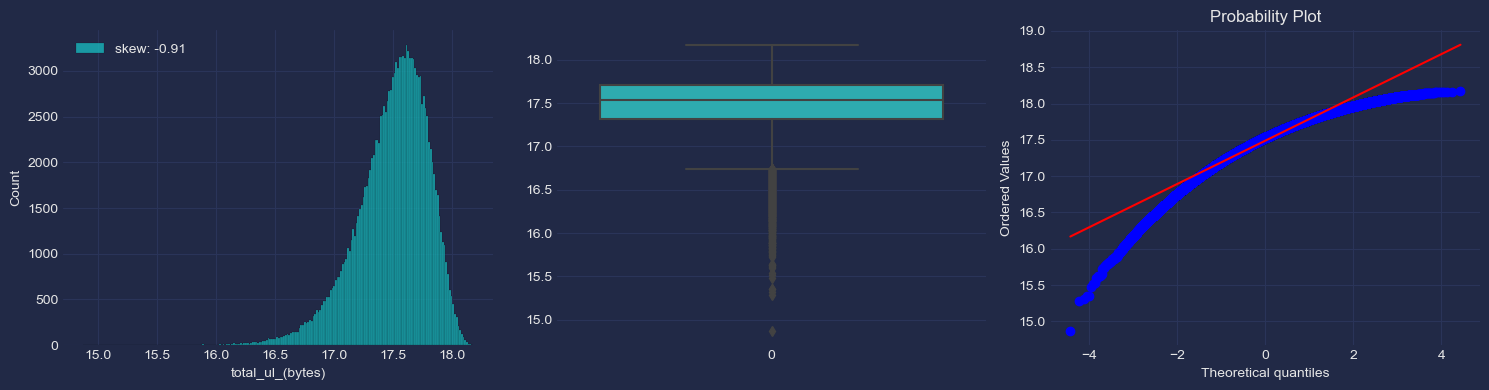

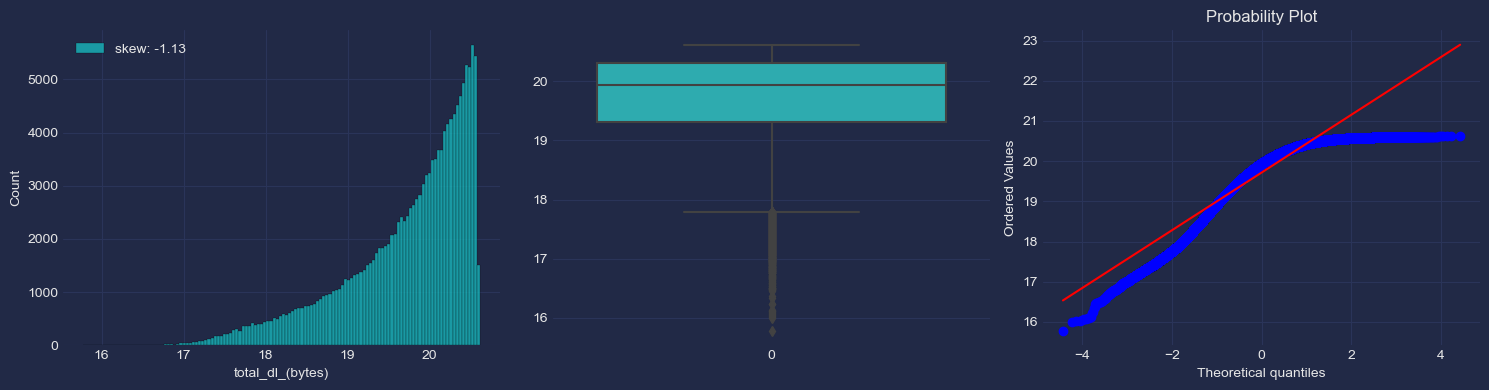

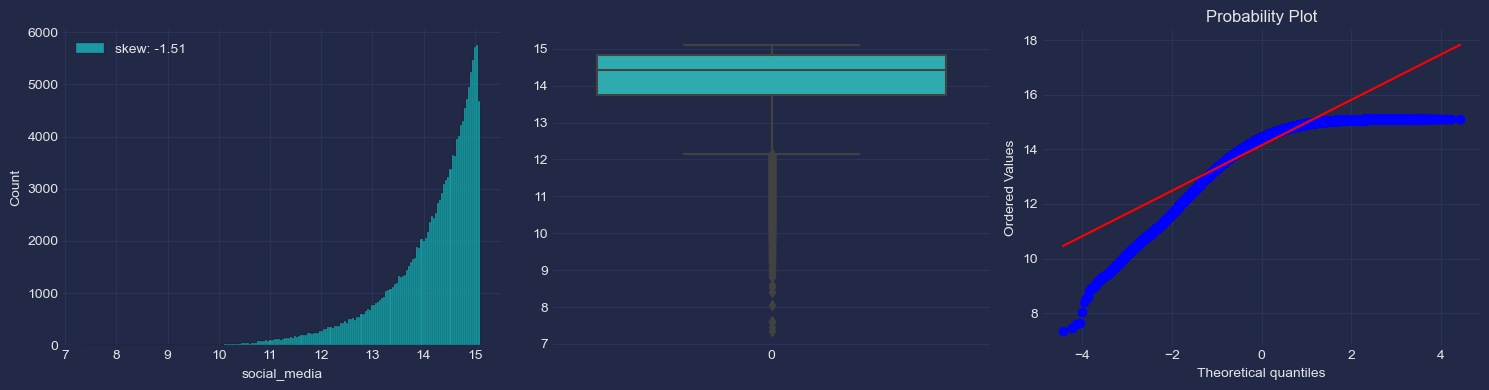

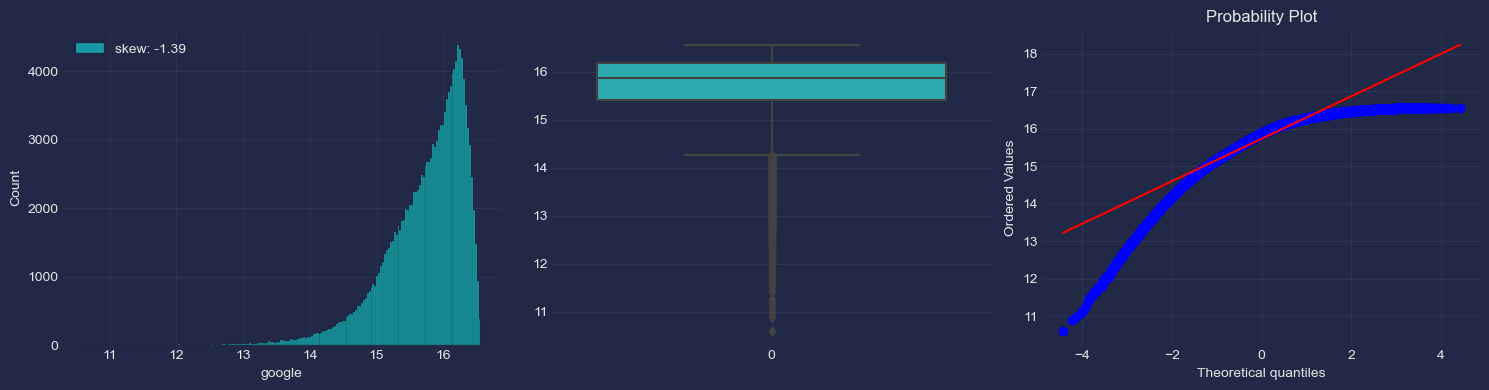

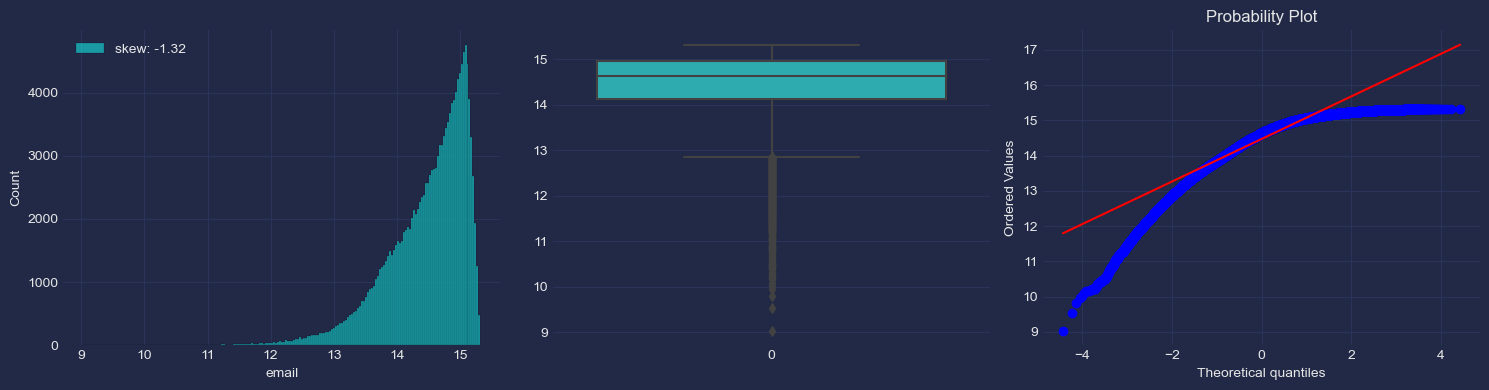

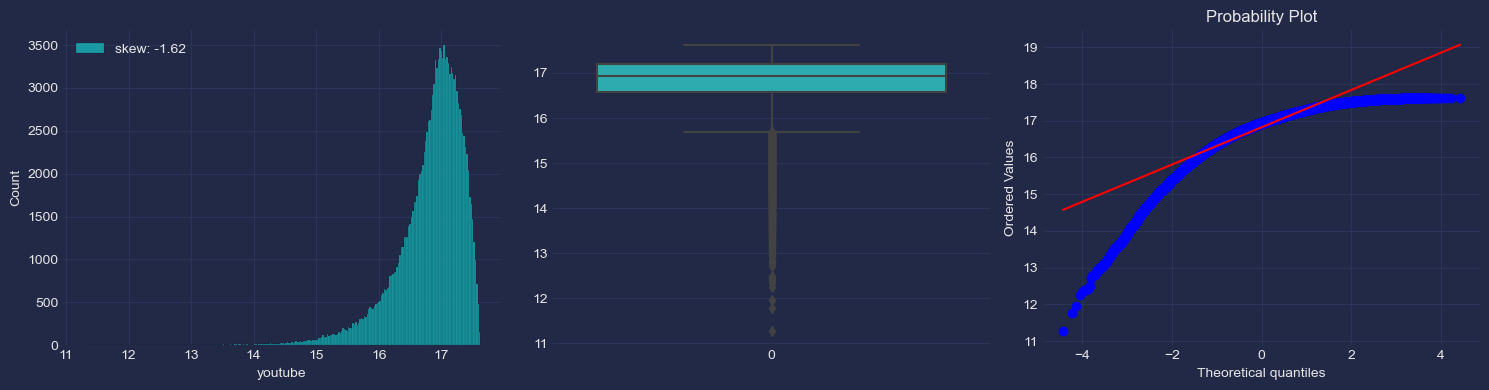

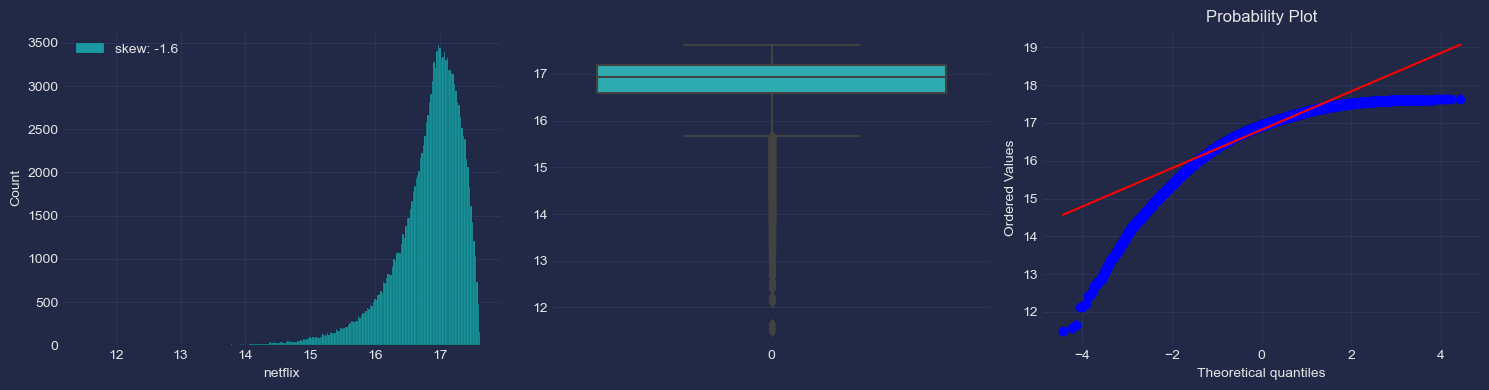

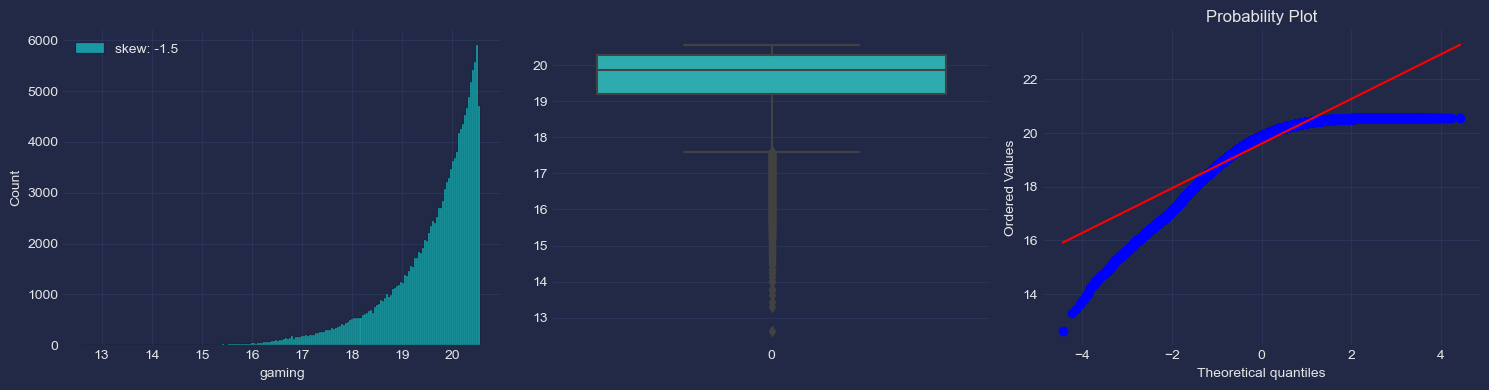

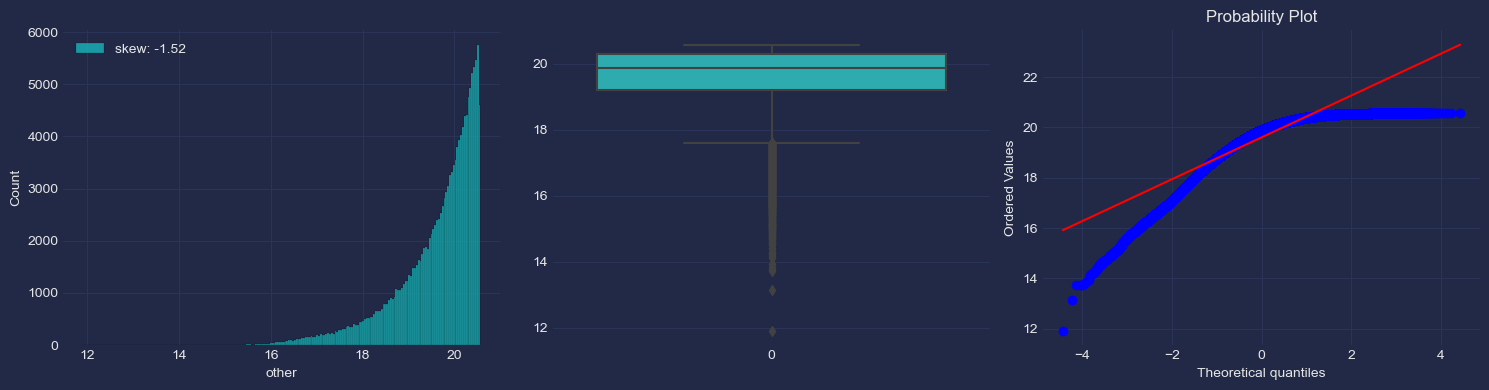

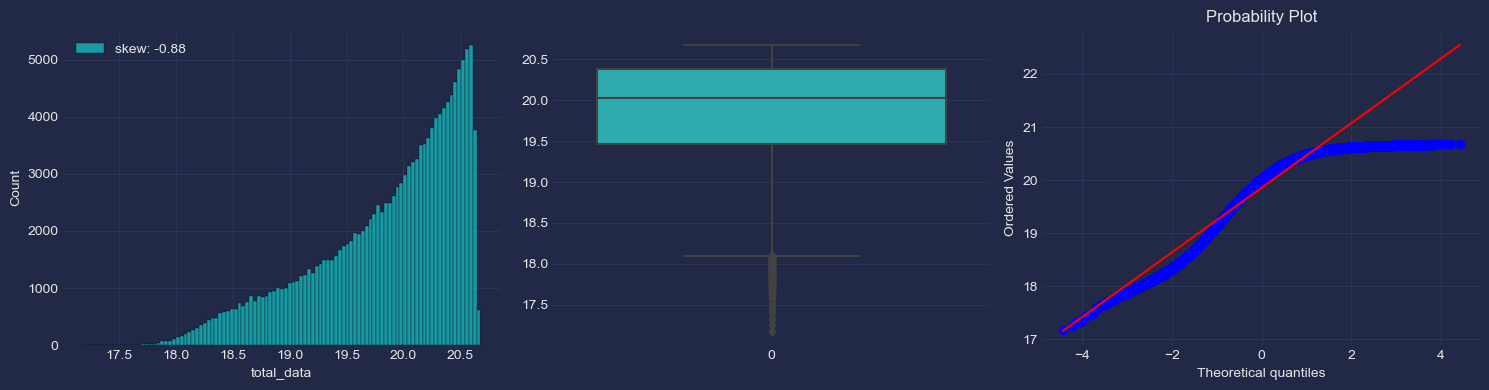

In [116]:
#sns.set_style('dark')
for col in columns_with_outliers:
    plt.figure(figsize=(15,4))
    plt.subplot(131)
    sns.histplot(df_outlier[col], label="skew: " + str(np.round(df_outlier[col].skew(),2)))
    plt.legend()
    plt.subplot(132)
    sns.boxplot(df_outlier[col])
    plt.subplot(133)
    stats.probplot(df_outlier[col], plot=plt)
    plt.tight_layout()
    plt.show()


The method of using Z scores for capping/ trimming the outliers is valid ONLY if the particular feature is normally distributed. Since most of the fetures in our data dataset are NOT normally distributed, we should use other techniques, one of which is this IQR method

In [117]:
## Capping

In [118]:
# Function to cap outliers using IQR method
def cap_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculating lower and upper bounds for capping
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Capping values beyond the lower and upper bounds
    capped_df = df.clip(lower=lower_bound, upper=upper_bound, axis=1)
    
    return capped_df


In [119]:
df_caped = cap_outliers_iqr(df_clean[numeric_columns])

/home/eyaya/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [120]:
df_cap = df_caped[columns_with_outliers]

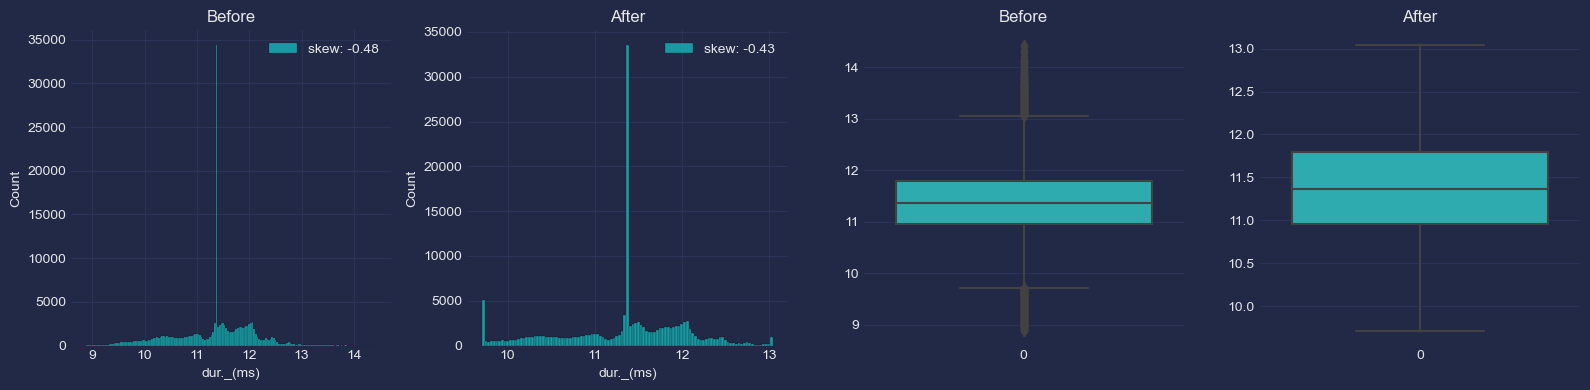

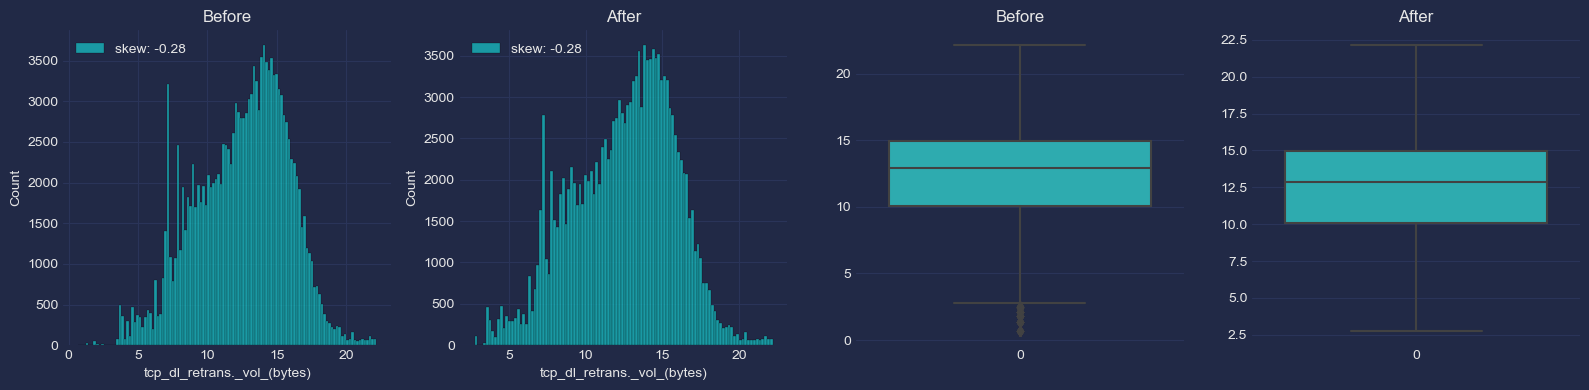

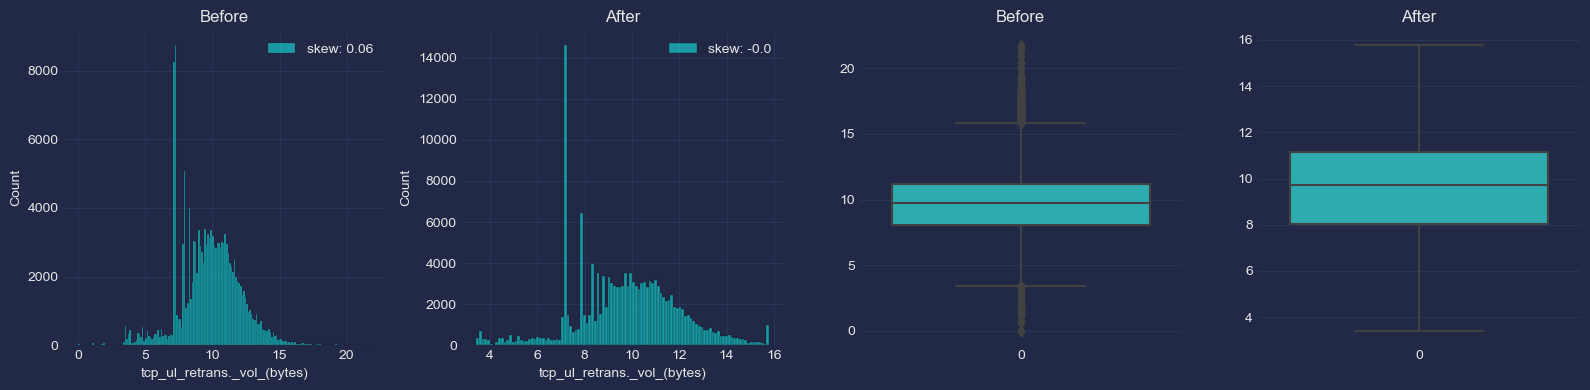

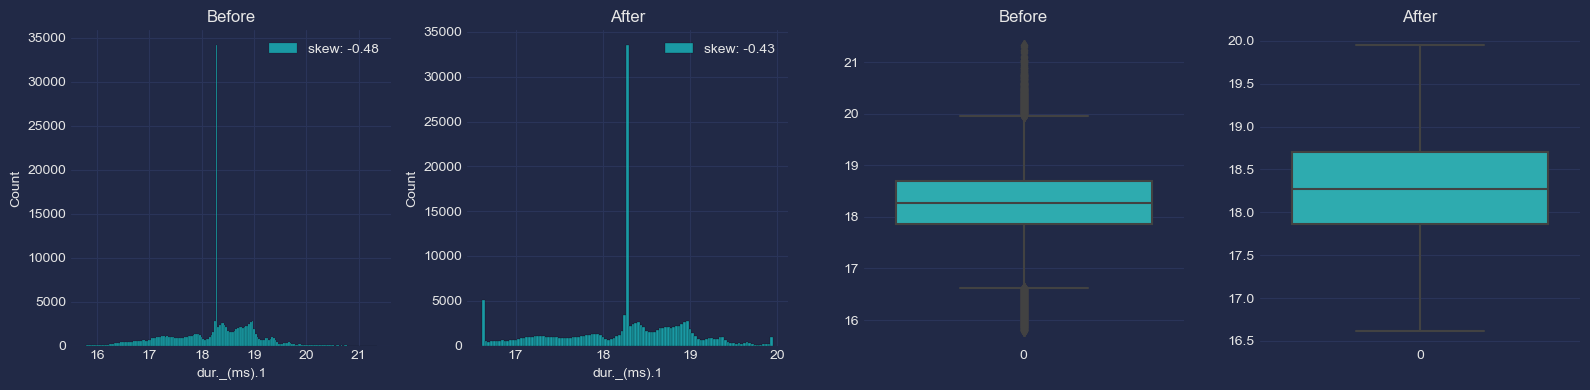

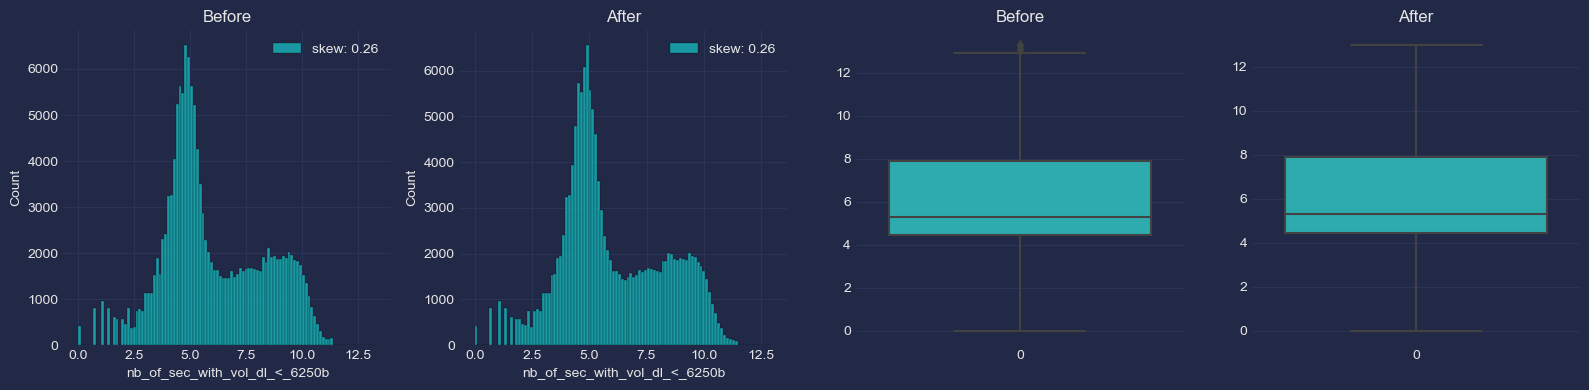

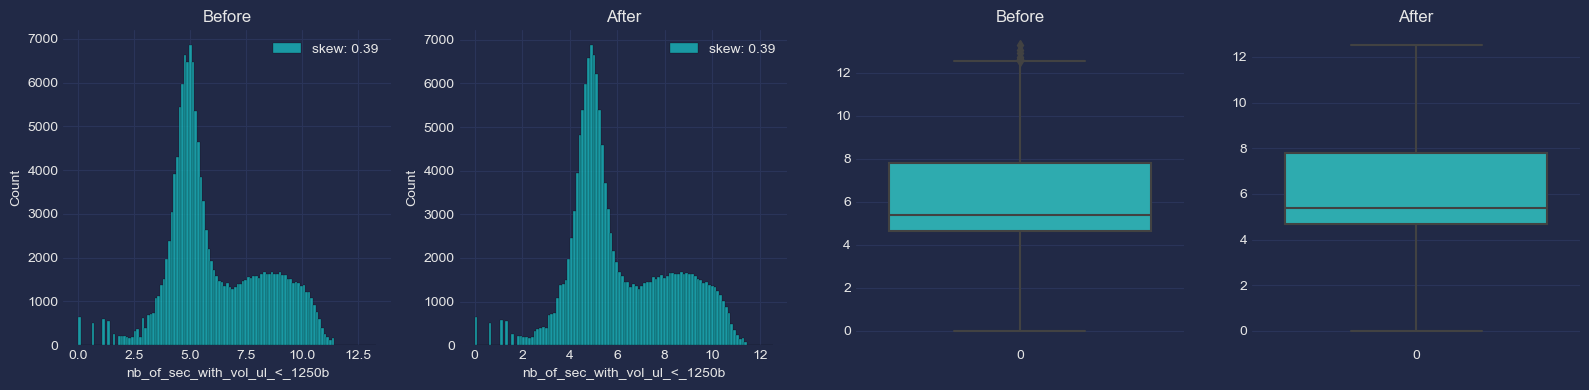

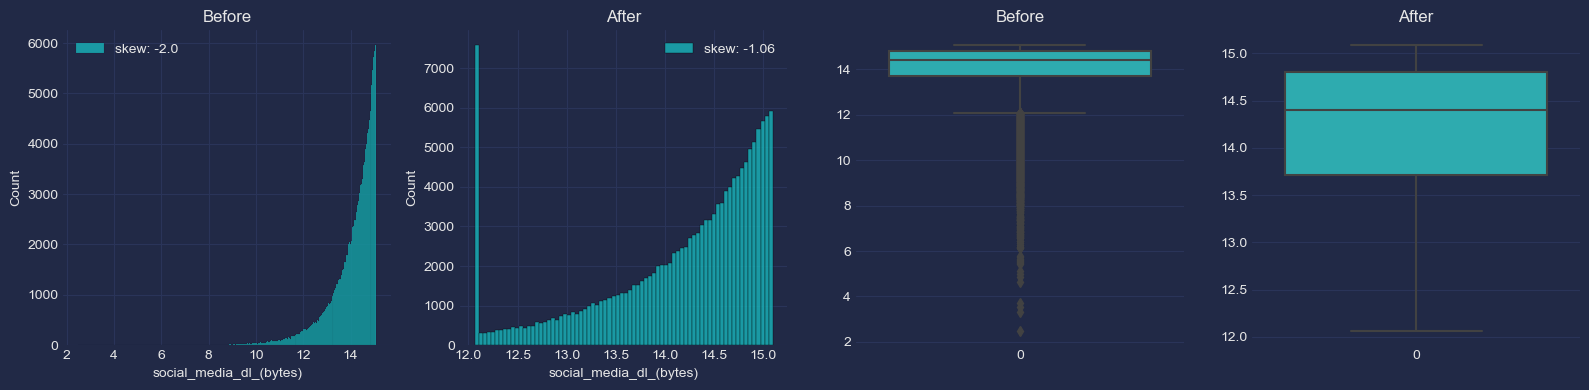

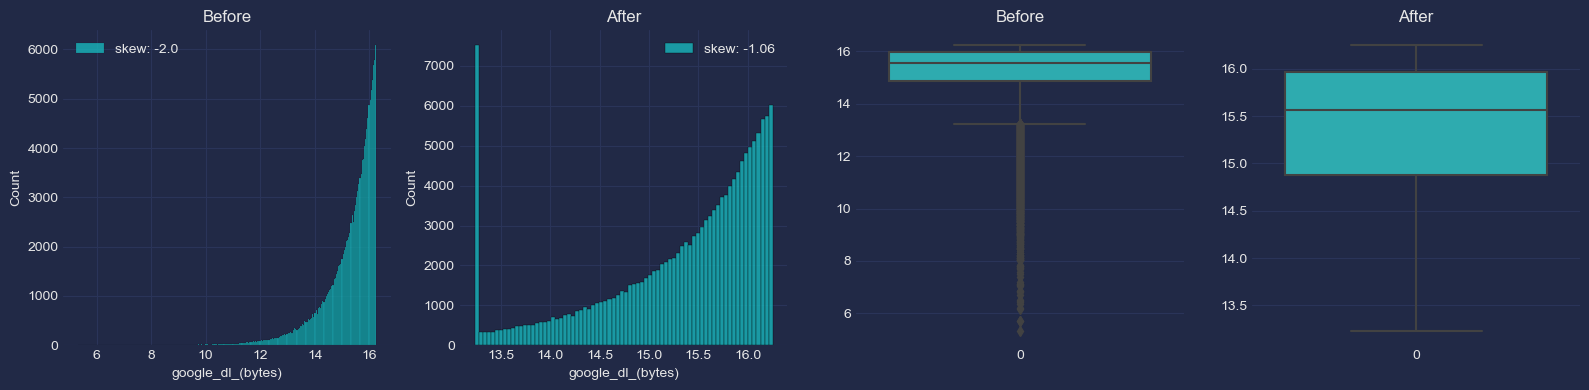

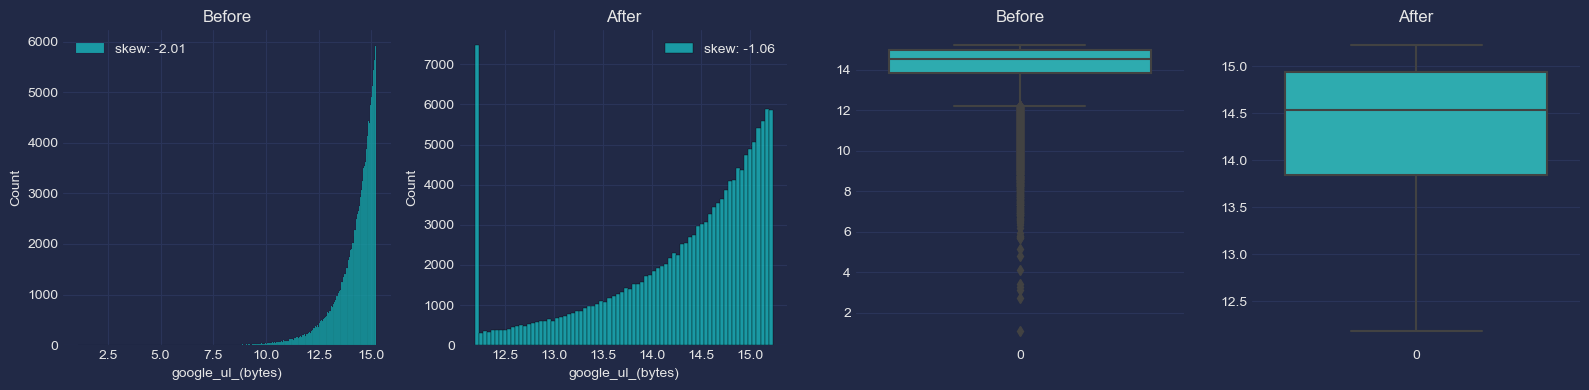

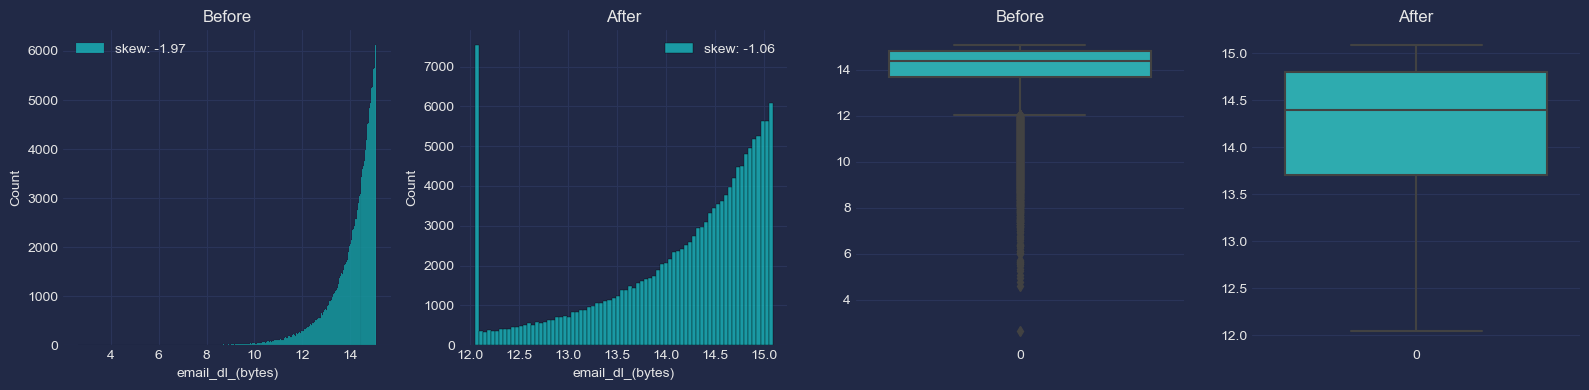

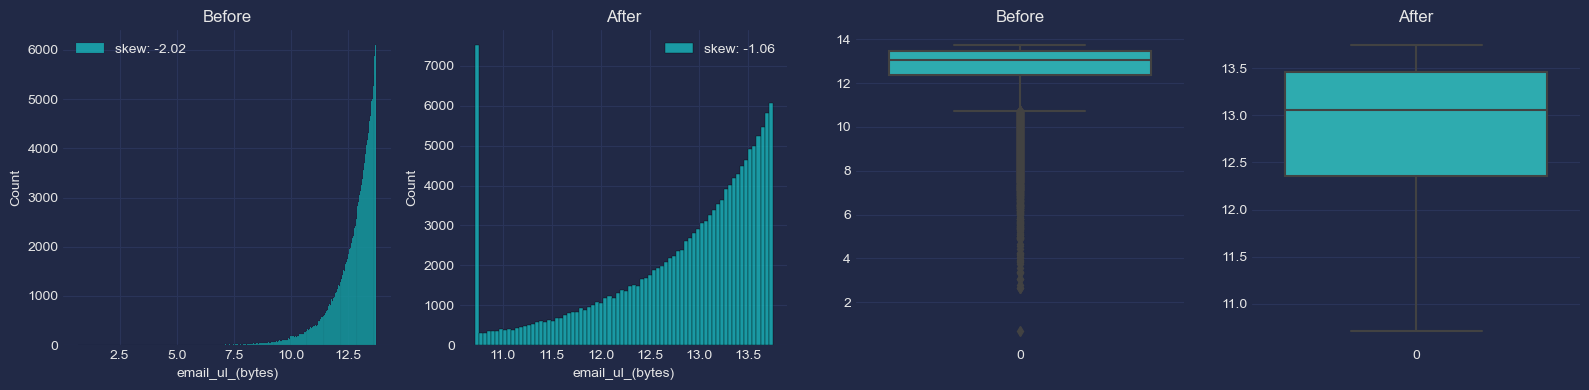

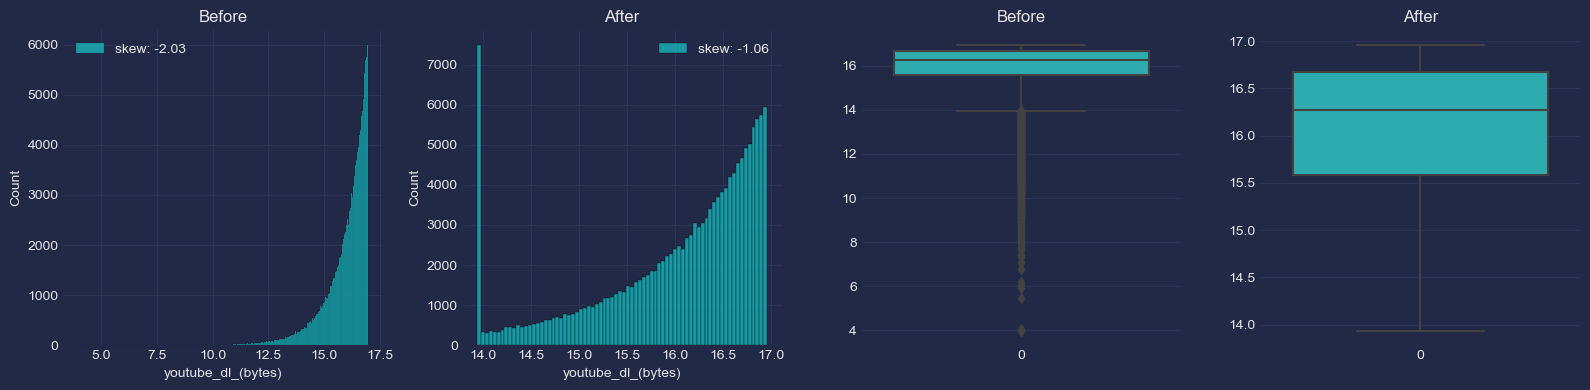

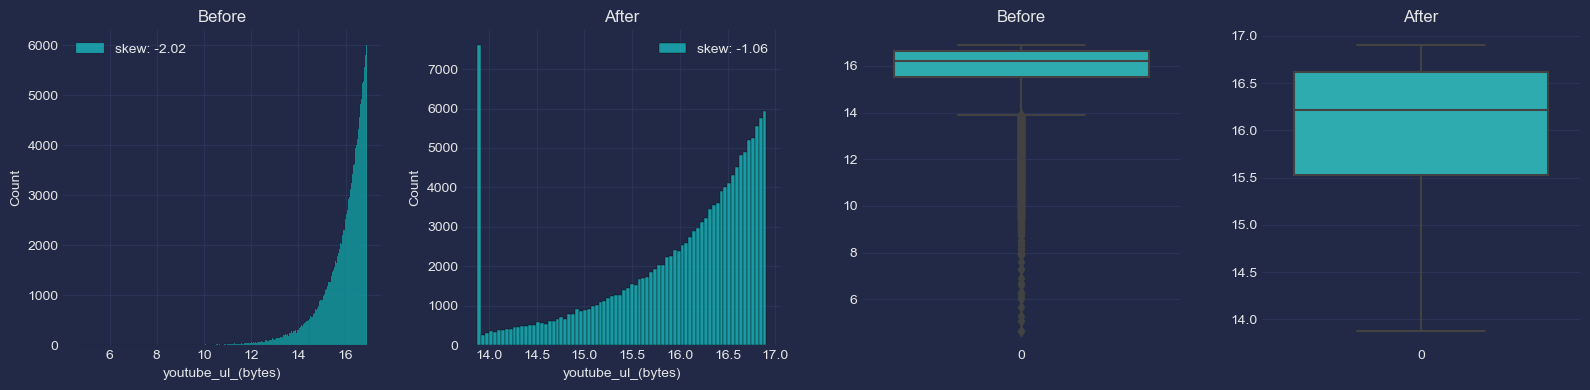

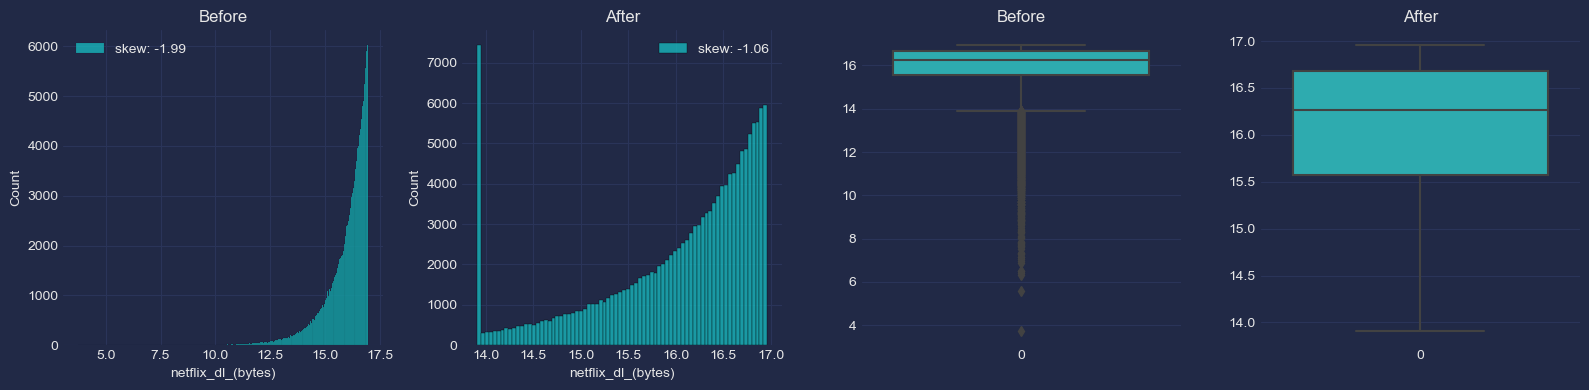

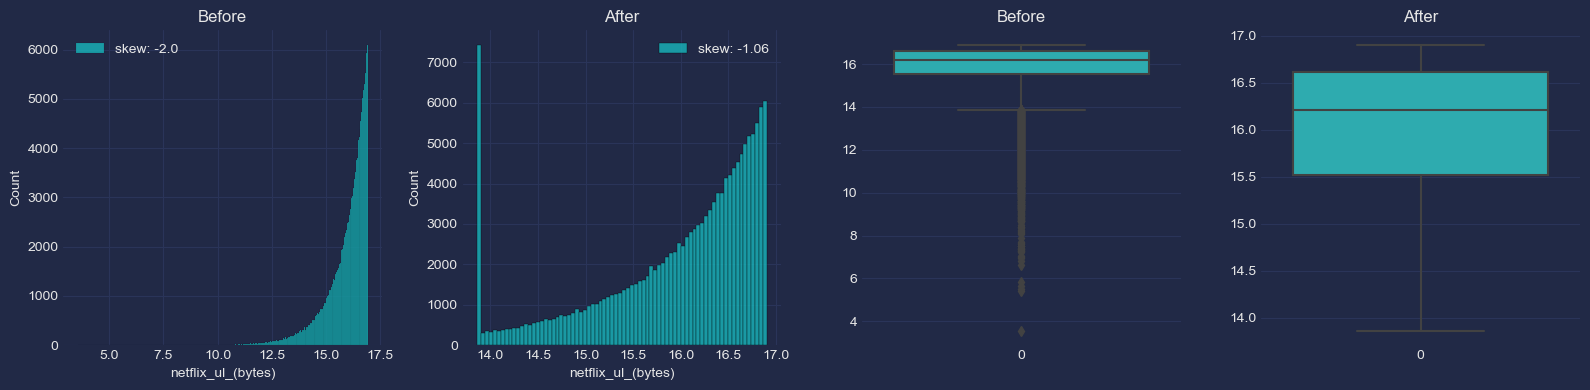

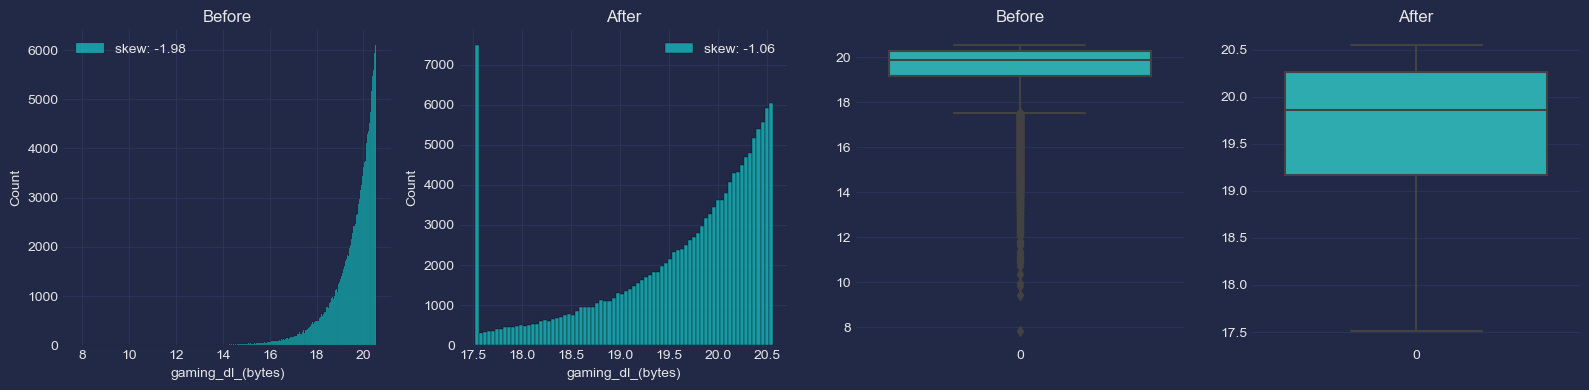

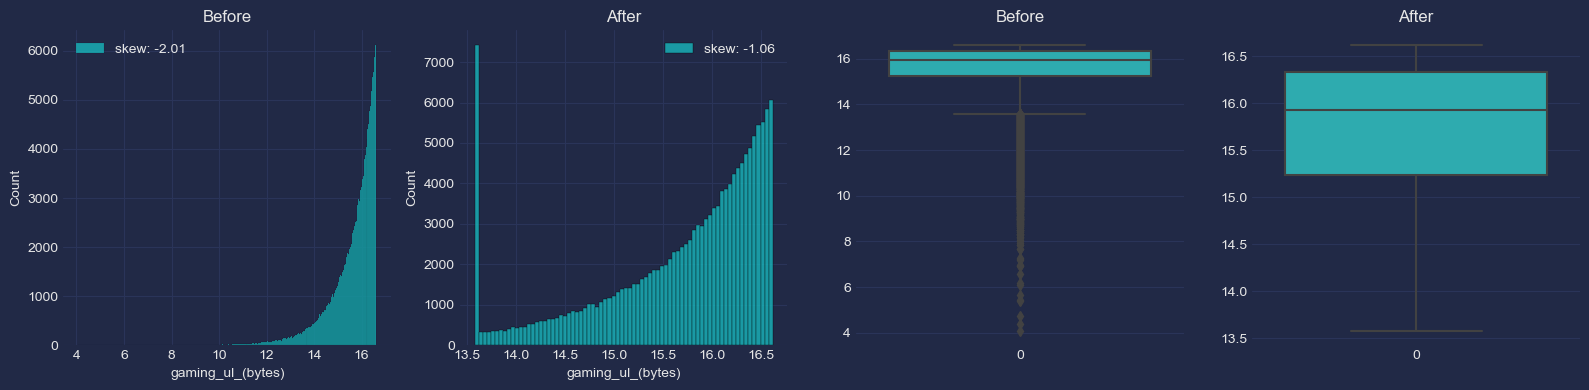

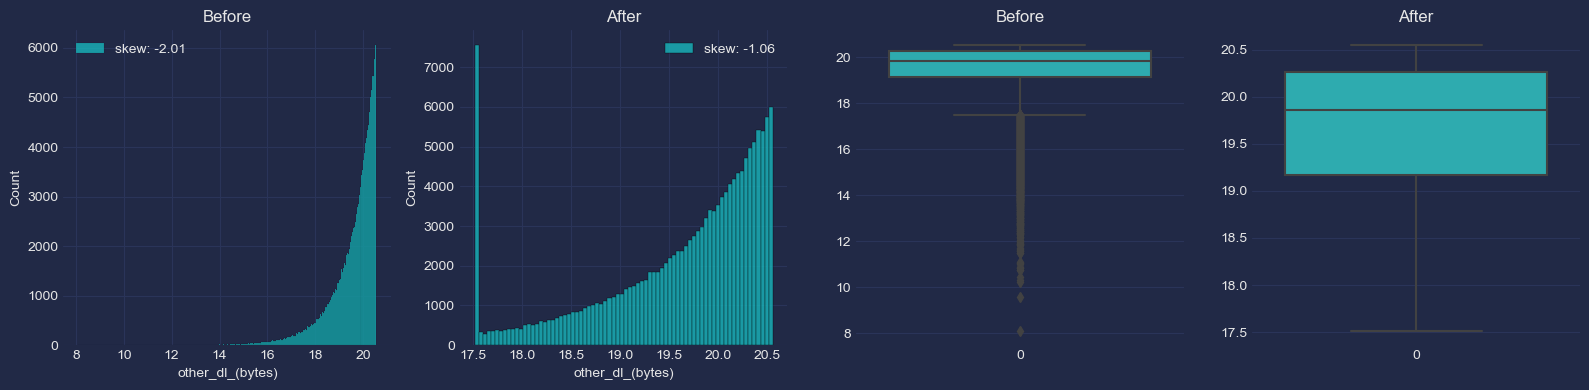

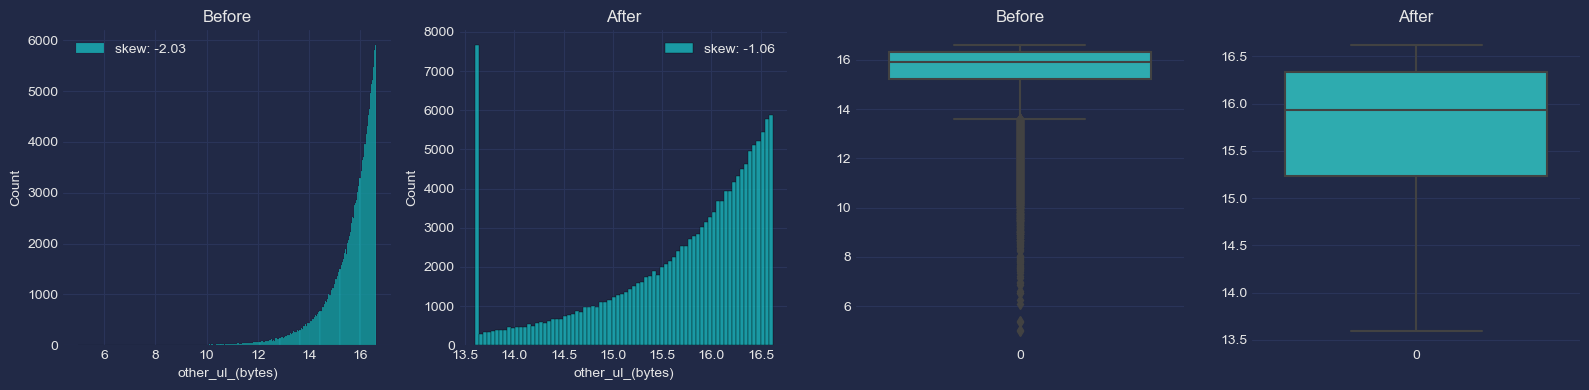

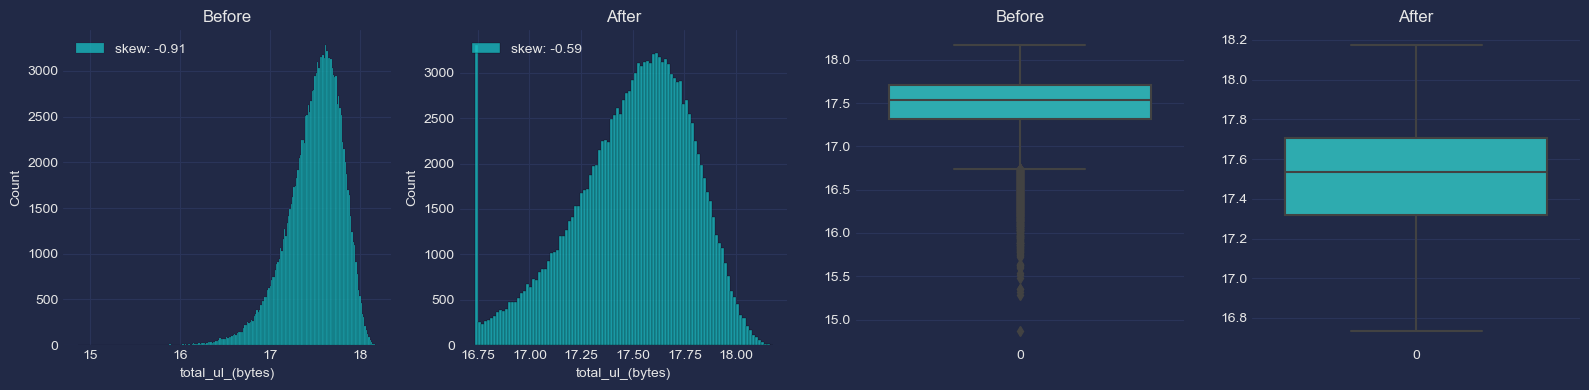

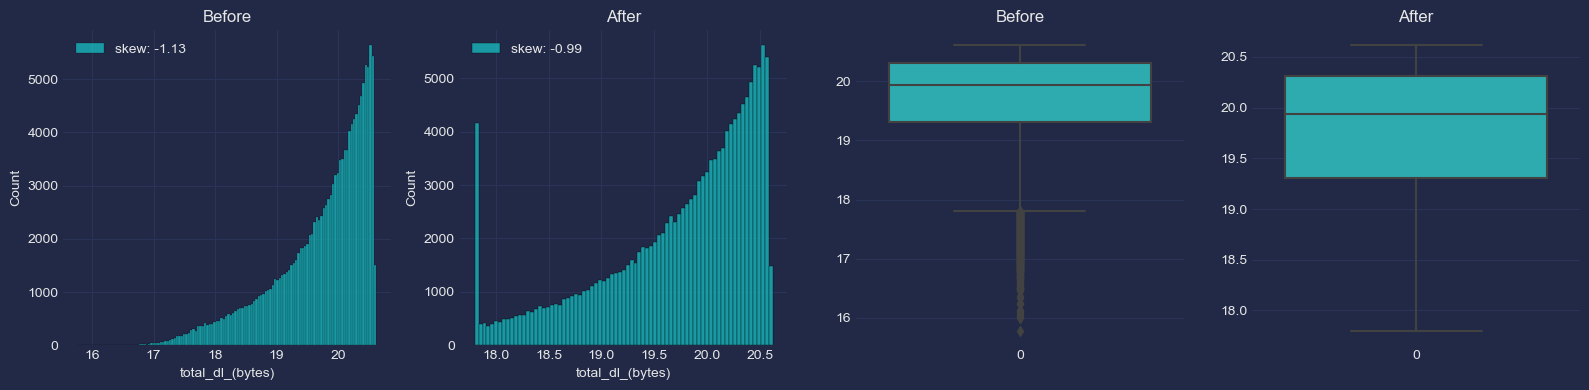

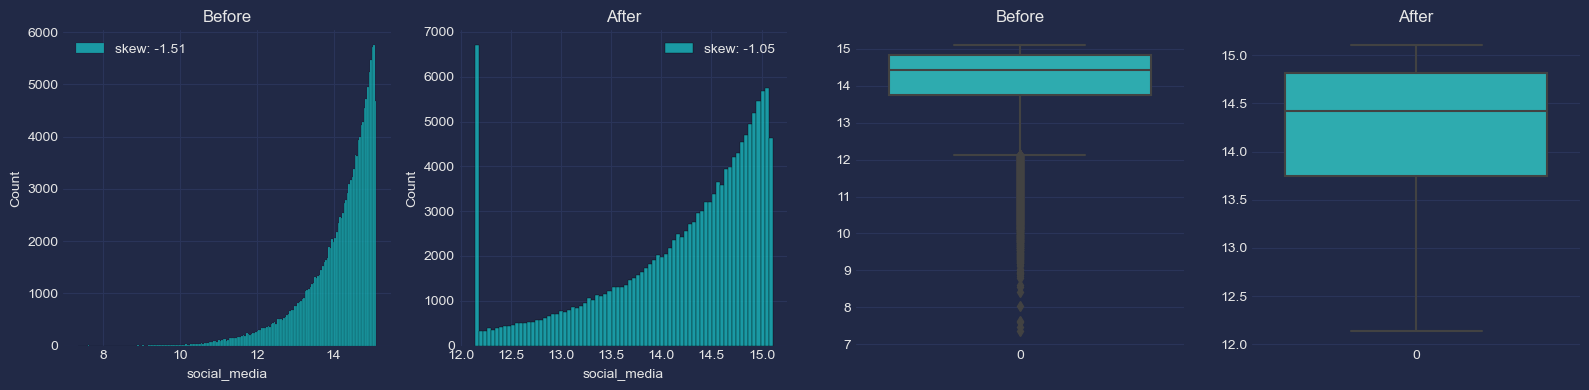

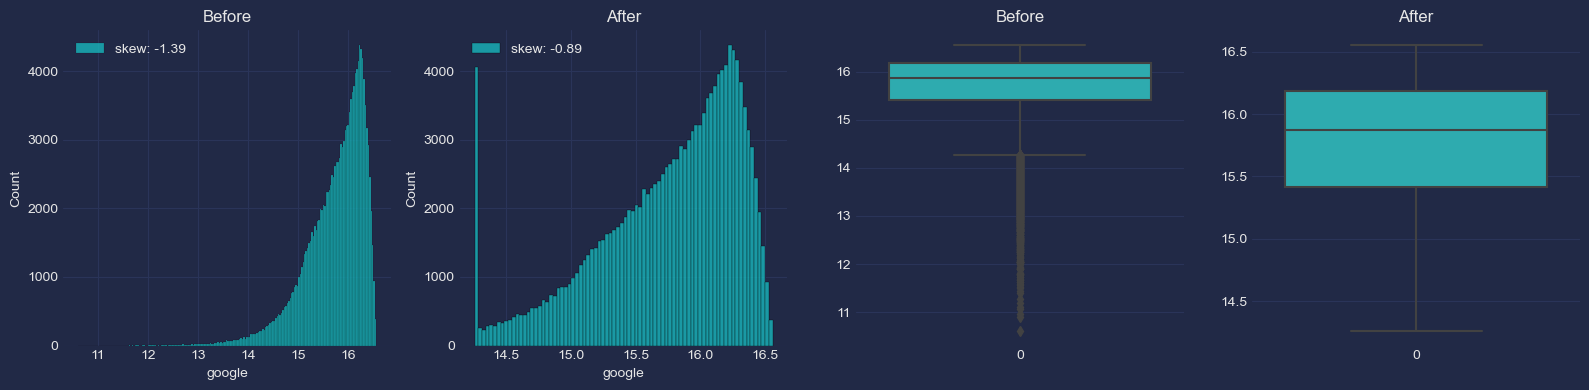

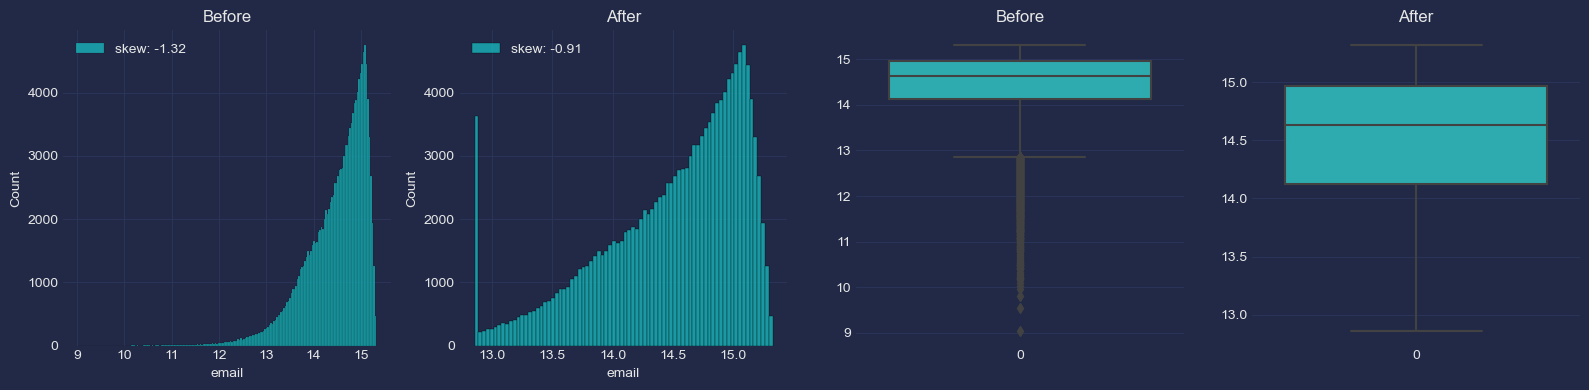

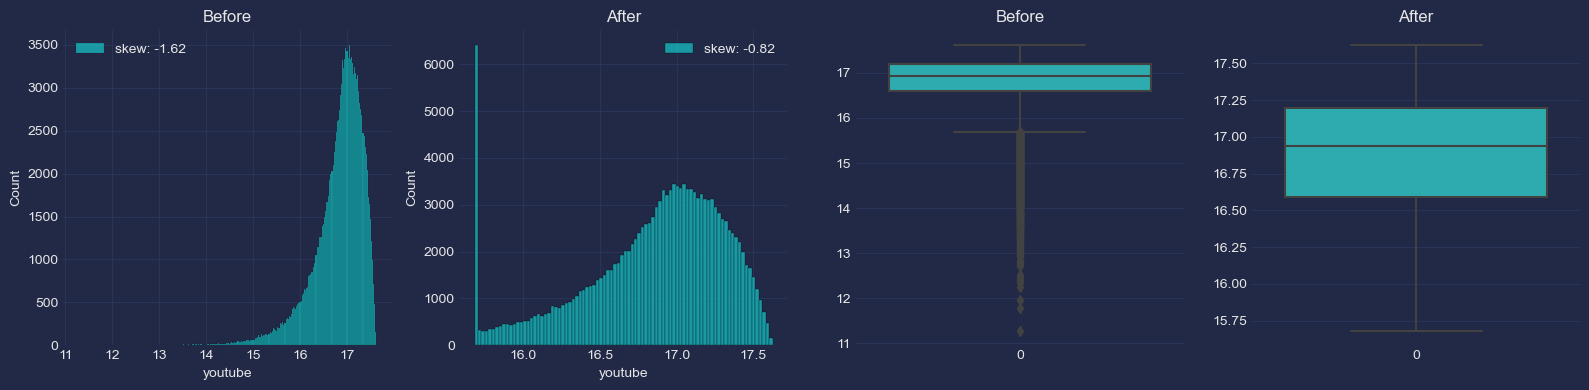

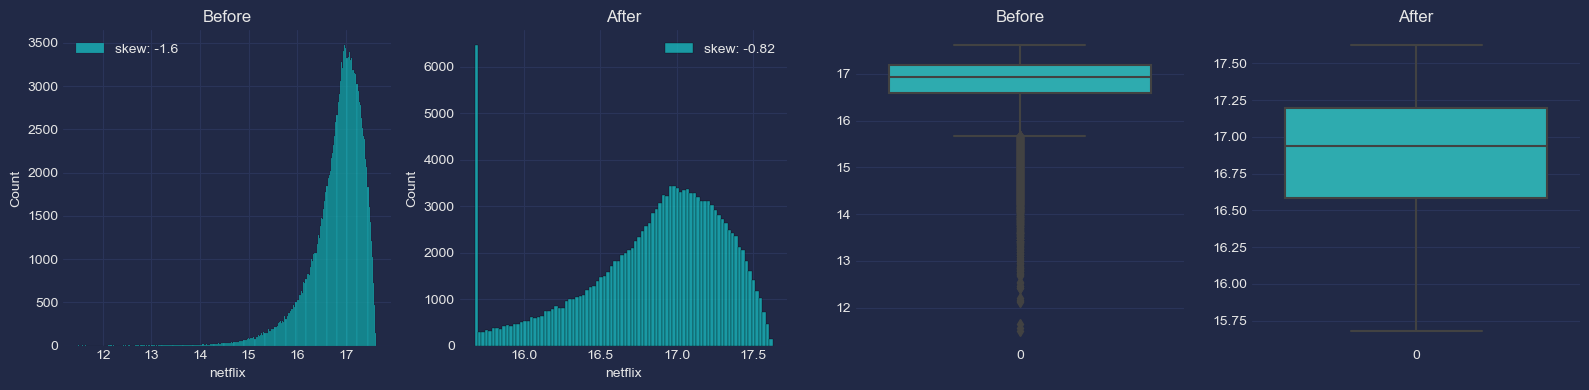

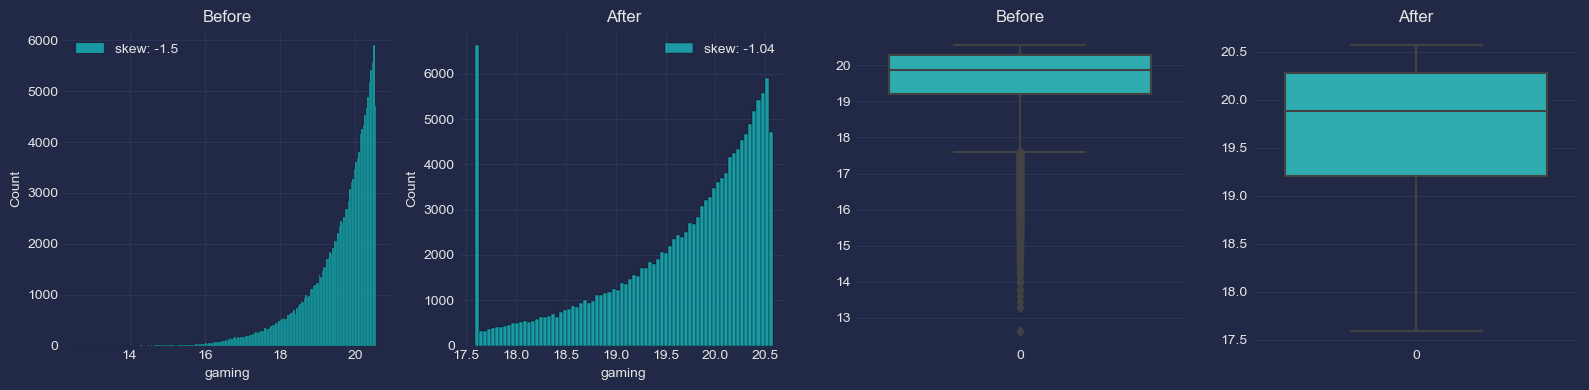

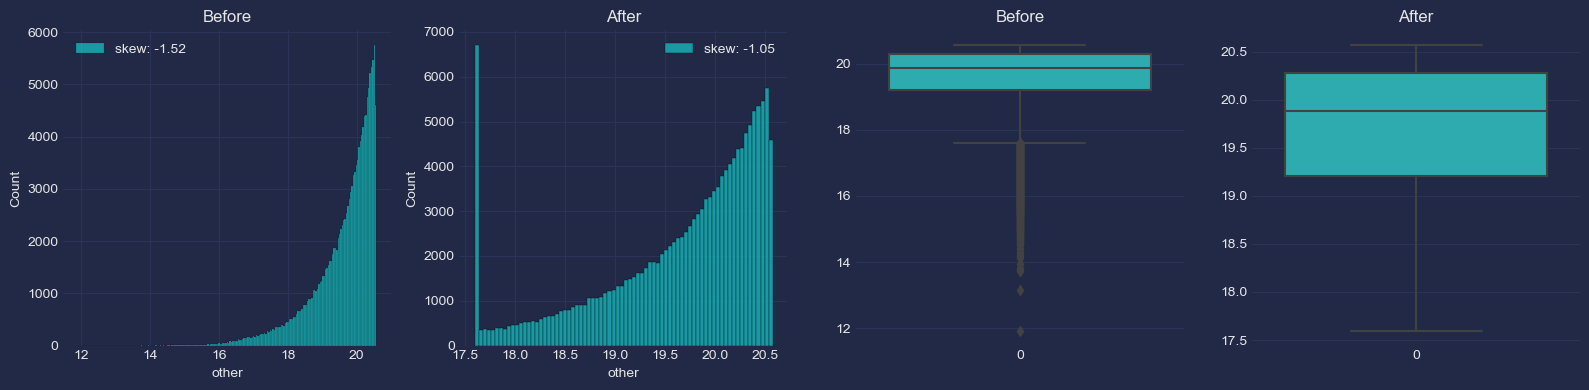

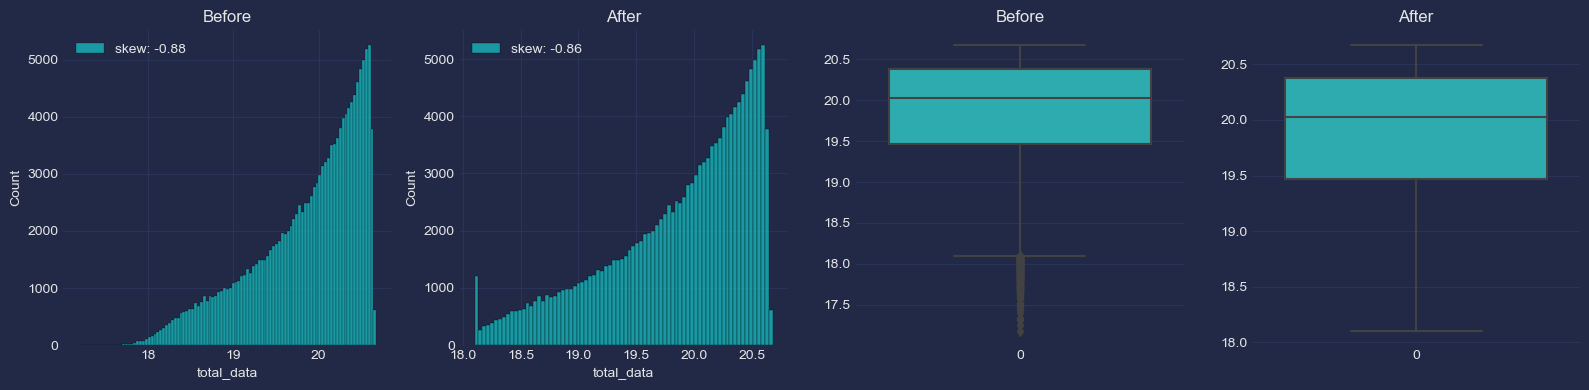

In [121]:
df = df_outlier.copy()
for col in columns_with_outliers:
    plt.figure(figsize=(16,4))
    
    plt.subplot(141)
    sns.histplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))
    plt.title('Before')
    plt.legend()
    
    plt.subplot(142)
    sns.histplot(df_cap[col], label="skew: " + str(np.round(df_cap[col].skew(),2)))
    plt.title('After')
    plt.legend()
    
    plt.subplot(143)
    sns.boxplot(df[col])
    plt.title('Before')
    
    plt.subplot(144)
    sns.boxplot(df_cap[col])
    plt.title('After')
    plt.tight_layout()
    plt.show()

In [122]:
df_clean[numeric_columns] = df_caped[numeric_columns]

In [123]:
df_clean.to_csv('../data/outlier_data.csv', index=False)